# 第一版因子分析研究流程

In [8]:
# import module
import model
import pandas as pd
from comm import func
import scipy.stats as stats
import csv
import numpy as np
import matplotlib.pyplot as plt
import traceback
import seaborn as sns
import os
import time


# 函数与功能

In [9]:
# tool func 
# 用于归一化
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def get_list_order(factorValues):
    x = np.array(factorValues)
    a = np.argsort(-x, axis=1)  # 降序index
    a = pd.DataFrame(a)
    a['trade_date'] = factorValues[0].index
    a = a.set_index(['trade_date'])
    return a

# 计算ic值
def get_IC_value(currency_num, currency_return_list):
    x = np.array(currency_num)
    a = np.argsort(-x)
    y = np.array(currency_return_list)
    b = np.argsort(-y)
    c = stats.pearsonr(a, b)
    return c[0]

# 矩阵化相关性绘制heatmap
def heatmap(x_title, x_axis, y_title, y_axis, datas, title, showplt=False, saveplt=True, savepath=None):
    datas2 = []
    labels2 = []
    for i in range(len(datas)):
        # print(y_axis[i],)
        x = np.array(datas[i])
        a = np.argsort(x)  # 降序index
        da = []
        la = []
        for index in a:
            da.append(round(datas[i][index], 2))
            la.append(x_axis[index] + "\n(" + str(round(datas[i][index], 2)) + ")")
        datas2.append(da)
        labels2.append(la)
        #     value=x_axis[index]+":"+str(round(datas[i][index],2))
        #     lis.append(value)
        # print(y_axis[i],lis)
    f, ax1 = plt.subplots(figsize=(10, 6), nrows=1)
    cmap = sns.light_palette("green", 8, as_cmap=True)
    cmap = sns.color_palette("Blues", 8, as_cmap=True)
    sns.heatmap(datas2, annot=labels2, ax=ax1, vmax=0, vmin=1, cmap=cmap, fmt="")
    ax1.set_title(title)
    # ax1.set_xlabel(x_title)
    # ax1.set_xticklabels(x_axis,rotation=45)
    # ax1.set_ylabel(y_title)
    ax1.set_yticklabels(y_axis, rotation=0)
    if showplt:
        plt.show()
    if saveplt:
        f.savefig(os.path.join(savepath, title + ".png"))
        


In [10]:
# analysis module
# 计算pearsonr相关系数
def calculate_pearsonr(startdate1, enddate1, frenquncy, datas, datafreq, factor_list, outdir='D:/result/', symbols=None,
                       showplt=False, saveplt=True):
    date_range = pd.date_range(startdate1, enddate1, freq=frenquncy)
    results = {}
    csvfile = outdir + '因子相关性测试.csv'
    if os.path.exists(csvfile):
        os.remove(csvfile)
    for symbol, data in datas[datafreq].items():
        if symbols is None or (symbol in symbols):
            factor_values = []
            data = datas[datafreq][symbol]
            for findex in range(len(factor_list)):
                f = factor_list[findex][0]
                if f == func.get_market_caps:
                    factor_values.append(f(data, None, matrix=True)[date_range].values)
                else:
                    days = factor_list[findex][1]
                    factor_values.append(f(data, None, days, datafreq, matrix=True)[date_range].values)
            x_axis = []
            y_axis = []
            mapvalues = []
            mapnoses = []
            for i in range(len(factor_values)):
                fname = factor_list[i][0].__name__
                if fname.find('get_') == 0:
                    fname = fname.split('_')[-1]
                else:
                    fname = fname.split('_')[0]
                fname = fname + str(factor_list[i][1])
                x_axis.append(fname)
                y_axis.append(fname)
                vals = []
                nose_vals = []
                for j in range(len(factor_values)):
                    try:
                        c = stats.pearsonr(factor_values[i], factor_values[j])
                        row1 = [symbol, factor_list[i][0].__name__ + str(factor_list[i][1]),
                                factor_list[j][0].__name__ + str(factor_list[j][1]), c[0], c[1]]
                        # mapvalues.append([i,j,c[0]])
                        # mapnoses.append([i,j,c[1]])
                        vals.append(c[0])
                        nose_vals.append(c[1])
                        with open(csvfile, "a", newline='') as output:
                            # 用于放置获取结果的CSV
                            writer = csv.writer(output)
                            writer.writerow(row1)
                    except:
                        print('decode error happens')
                        traceback.print_exc()
                mapvalues.append(vals)
                mapnoses.append(nose_vals)
            heatmap('x', x_axis, 'y', y_axis, mapvalues, symbol, showplt, saveplt, outdir)
            heatmap('x', x_axis, 'y', y_axis, mapnoses, symbol + '-nose', showplt, saveplt, outdir)


def symbol_pearsonr(startdate1, enddate1, frenquncy, datas, datafreq, factor_list, outdir='D:/result/', symbols=None,
                    showplt=False, saveplt=True):
    csvfile = outdir + '因子相关性测试.csv'
    if os.path.exists(csvfile):
        os.remove(csvfile)
    x_axis = []
    y_axis = []
    map_values = []
    map_noses = []
    all = []
    for i in range(len(symbols)):
        fname = symbols[i]
        x_axis.append(fname.replace('USDT', ''))
        y_axis.append(fname.replace('USDT', ''))
        vals = []
        nose_vals = []
        curr = []
        for j in range(len(symbols)):
            try:
                maxs = datas[datafreq][symbols[i]]['close'].index[0]
                s2 = datas[datafreq][symbols[j]]['close'].index[0]
                if maxs < s2:
                    maxs = s2
                c = stats.pearsonr(datas[datafreq][symbols[i]]['close'][maxs:enddate1],
                                   datas[datafreq][symbols[j]]['close'][maxs:enddate1])
                row1 = [symbols[i].replace('USDT', ''), symbols[j].replace('USDT', ''), c[0], c[1]]
                if c[0] < 0.5:
                    curr.append(symbols[j] + str(',') + str(round(c[0], 2)))
                # mapvalues.append([i,j,c[0]])
                # mapnoses.append([i,j,c[1]])
                vals.append(c[0])
                nose_vals.append(c[1])
                with open(csvfile, "a", newline='') as output:
                    # 用于放置获取结果的CSV
                    writer = csv.writer(output)
                    writer.writerow(row1)
            except:
                print(fname, 'decode error happens')
                traceback.print_exc()
        map_values.append(vals)
        map_noses.append(nose_vals)
        if len(curr) > 0:
            curr.insert(0, fname)
            print(curr)
    hindex = []
    lindex = []
    heatmap('x', x_axis, 'y', y_axis, map_values, 'symbol', showplt, saveplt, outdir)
    heatmap('x', x_axis, 'y', y_axis, map_noses, 'symbol-nose', showplt, saveplt, outdir)

# 因子收益
def factor_profit(startdate, enddate, datas, datafreq, factor_list, weight_list, period=7, outdir='D:/result/',
                  symbols=None, showplt=False, saveplt=True, title='title',group=1):


    def get_value_matrix(datas, end_date, data_freq, factor_list, weight_list):
        dics = {}
        for symbol in symbols:
            data = datas[symbol]
            fvalues = []
            for findex in range(len(factor_list)):
                f = factor_list[findex][0]
                if f == func.get_market_caps:
                    fvalues.append(f(data, end_date, matrix=True) * weight_list[findex])
                else:
                    days = factor_list[findex][1]
                    fval = f(data, end_date, days, data_freq, matrix=True)
                    # fval=sigmoid(fval)
                    fvalues.append(fval * weight_list[findex])
            dics[symbol] = sum(fvalues)[startdate:end_date]
        return dics

    symbol_length = len(symbols)
    factor_values = get_value_matrix(datas[datafreq], None, datafreq, factor_list, weight_list)
    factor_values = pd.concat(factor_values, axis=1)
    factor_values.columns = range(symbol_length)
    factor_order = get_list_order(factor_values)
    factor_order.columns = range(symbol_length)
    close_profit = {}
    close = {}
    date_ranges = pd.date_range(startdate, enddate, freq=(str(period) + datafreq[-1]))
    for symbol in symbols:
        data = datas[datafreq][symbol]
        close_profit[symbol] = data['Close'] - data['Close'].shift(period)
        close[symbol] = data['Close']
    real_profits = [0] * symbol_length
    expect_profits = [0] * symbol_length
    lastdate = None
    mapvalues = [[0] * 6] * symbol_length
    repearson = []
    dates = []
    groupdatas = []
    try:
        for currentdate in date_ranges:
            if lastdate is None:
                lastdate = currentdate
                continue
            current = []
            expectsort = []
            for i in range(symbol_length):
                try:
                    symbol = symbols[i]
                    current.append(1 / close[symbol][lastdate] * close_profit[symbol][currentdate])
                except Exception as e:
                    print(symbol,e)
            realsort = np.argsort(-np.array(current))
            current.sort()

            for i in range(symbol_length):
                try:
                    expectsort.append(factor_order[i][lastdate])
                    symbol = symbols[factor_order[i][lastdate]]
                    expect_profits[i] = expect_profits[i] + 1 / close[symbol][lastdate] * close_profit[symbol][currentdate]
                    real_profits[i] = real_profits[i] + current[symbol_length - i - 1]
                    groupindex = int(i / group)
                    if groupindex >= len(groupdatas):
                        groupdatas.append([])
                    if len(dates) >= len(groupdatas[groupindex]):
                        groupdatas[groupindex].append(0)
                    groupdatas[groupindex][len(dates)] = groupdatas[groupindex][len(dates)] + round(
                        1 / close[symbol][lastdate] * close_profit[symbol][currentdate], 2)
                except Exception as e:
                    print(symbol,e)
                # lastsymbolindex=factororder[i][lastdate]
                # nowindex=1
            c = stats.pearsonr(realsort, expectsort)
            repearson.append(c[0])
            dates.append(str(currentdate.date()))
    except Exception as e:
        print(symbol)
        traceback.print_exc()

    num = len(date_ranges)
       
    plt.figure(figsize=(20,10), dpi = 300)
    plt.plot(dates, [np.mean(np.array(repearson))] * len(repearson), color='r')
    plt.plot(dates, repearson)
    plt.xticks(dates, rotation=45)
    plt.show()
    plt.figure(figsize=(20,10), dpi = 300)
    titles = []
    for i in range(len(groupdatas)):
        plt.plot(dates, groupdatas[i])
        titles.append(str(i * group) + '-' + str(i * group + group - 1))
    plt.xticks(dates, rotation=45)
    plt.legend(tuple(titles))
    plt.show()
    for i in range(symbol_length):
        real_profits[i] = real_profits[i] / num
        expect_profits[i] = expect_profits[i] / num
    bar_width = 0.2
    index = np.arange(symbol_length)
    plt.figure(figsize=(20,10), dpi = 300)
    plt.title(title + '_' + str(period))
    plt.bar(index, real_profits, color='green', width=bar_width)
    plt.bar(index + bar_width, expect_profits, color='blue', width=bar_width)
    plt.legend(('real', 'expected'))
    plt.xticks(index + 2 * bar_width / 2, range(symbol_length))
    if saveplt:
        plt.savefig(os.path.join(outdir, title + ".png"))
    if showplt:
        plt.show()
    plt.close()

    
# icrank的计算和绘制
def ic_rank(startdate1, enddate1, frenquncy, datas, datafreq, symbols=None):
    date_range = pd.date_range(startdate1, enddate1, freq=frenquncy)
    IC_list = []
    factor_list = [(func.get_n_days_reverse, 3),(func.get_n_days_volatility, 10),(func.get_n_days_liquidity, 5),
                   (func.BIAS_n_days, 5),(func.CCI_n_days, 5)]
    weight_list =[1, 1, 1, 1, 1]
    if symbols is None:
        symbols = list(datas[datafreq].keys())
    for i in range(1, len(date_range)):
        start = (date_range[i - 1].strftime("%Y%m%d"))
        end = (date_range[i].strftime("%Y%m%d"))
        factor_values = []
        ic_values = []
        for sindex in range(len(symbols)):
            fvalues = []
            for findex in range(len(factor_list)):
                f = factor_list[findex][0]
                days = factor_list[findex][1]
                fvalues.append(f(datas[datafreq][symbols[sindex]], start, days, datafreq) * weight_list[findex])
            ic_values.append(func.get_return_rate(datas[datafreq][symbols[sindex]], start, end))
            factor_values.append(sum(fvalues))
        result = get_IC_value(factor_values, ic_values)
        IC_list.append(result)
    
    # 数据处理
    date_range_1 = date_range[1:]
    IC_mean = np.mean(IC_list) # 均值
    IC_std = np.std(IC_list) # 标准差
    IC_abs_mean = np.mean(np.abs(IC_list)) # 绝对值均值
    icir = IC_mean/IC_std
    IC_np = np.array(IC_list)
#     print("here", np.where(IC_np > 0), len(np.where(IC_np > 0)[0]))
    IC_bigger_0 = (len(np.where(IC_np > 0)[0]))/(len(IC_list)) # >0
    IC_smaller_0 =  (len(np.where(IC_np < 0)[0]))/(len(IC_list)) # <0 
    absic = np.abs(IC_list)
    ic_002 = len(np.where(absic > 0.02)[0])/(len(IC_list)) # abs>0.02
    
    plt.figure(figsize=(20,10), dpi = 300)
    plt.plot(date_range_1, IC_list)
    plt.xticks(date_range_1, rotation=45)

    plt.show()
    
    plt.figure(figsize=(20,10), dpi = 300)
    crashes = pd.DataFrame({'date':date_range_1,'ic':IC_list}) # 制作画图数据集
    sns.distplot(crashes.ic,
                        kde=False,
                        color='b') # 单变量分布
    plt.title('IC_mean:{:.3f} \t IC_std:{:.3f} \t IC_abs_mean:{:.3f} \t IC>0:{:.3f} \t IC<0:{:.3f} \t icir:{:.3f}\t abs>0.02: {:.3f}'.format(IC_mean, IC_std, IC_abs_mean, IC_bigger_0, IC_smaller_0, icir, ic_002),fontdict={'fontsize': 20})

#     sns.set_theme(style="whitegrid")
#     f, ax = plt.subplots(figsize=(6, 15))
#     sns.set_color_codes("pastel")
#     sns.barplot(x="date", y="ic", data=crashes,
#                 label="Total", color="b")
    

  

# pipeline
 
``` 
0 读取数据
1 加工因子
2 计算IC 
3 计算收益
4 因子分析

### 单因子分析

通常，写完一个因子后我们需要进行单因子检验，逐个检验作为多因子模型的成分因子的效果，也是最重要的一部分。
所以在配置中factorlist设置为一个因子。

以 func.get_n_days_reverse, 10 为例 （反转因子）

#### 检验因子语法正确性

首先，对照因子的实际意义（反转因子值=当期price-回溯n天的price）检查语法是否正确


```py
            c = (data.loc[ndate_range[-1], 'close'] - data.loc[ndate_range[0], 'close']) / data.loc[
                ndate_range[0], 'close']
```

在因子编写的时候，需要备注因子名（即使是显著的意义，也需要注释，以防团队其他成员误解），如果因子有经济学意义，也可以稍作解释。



In [11]:
#初始化
start = time.time()
backtest_params = ['15T', '1H', '3H', '1D', '1T']
conf = model.data.get_config()
symbols = conf['symbols']
datas = model.data.get_data(types=backtest_params, symbols=symbols, starttime='2019-04-01', endTime='2021-10-08')
showplt = True
saveplt = False
factor_list = conf['factor_list']
weight_list = conf['weight_list']
outdir = conf['outdir']
print(conf)

{'factor_list': [(<function get_n_days_reverse at 0x000002733C7E3160>, 3), (<function get_n_days_volatility at 0x000002733B6D3F70>, 10), (<function get_n_days_liquidity at 0x000002733B6D3D30>, 5), (<function BIAS_n_days at 0x000002733B6D3DC0>, 5), (<function CCI_n_days at 0x000002733B6D3E50>, 5)], 'weight_list': [1, 1, 1, 1, 1], 'csv_path': {'1D': 'C:\\Users\\10249\\Desktop\\workspace\\1dD'}, 'cache_path': 'C:\\Users\\10249\\Desktop\\workspace\\cache', 'symbols': ['BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'LTCUSDT', 'NEOUSDT', 'XRPUSDT', 'QTUMUSDT', 'TRXUSDT', 'EOSUSDT', 'XLMUSDT', 'ONTUSDT', 'ETCUSDT', 'IOTAUSDT', 'VETUSDT', 'ICXUSDT', 'BTTUSDT', 'LINKUSDT', 'WAVESUSDT', 'ZILUSDT', 'HOTUSDT', 'XMRUSDT', 'ZECUSDT', 'BATUSDT', 'IOSTUSDT', 'DASHUSDT', 'ZRXUSDT', 'CELRUSDT', 'MATICUSDT', 'THETAUSDT', 'OMGUSDT'], 'outdir': 'C:\\Users\\10249\\Desktop\\workspace\\result'}


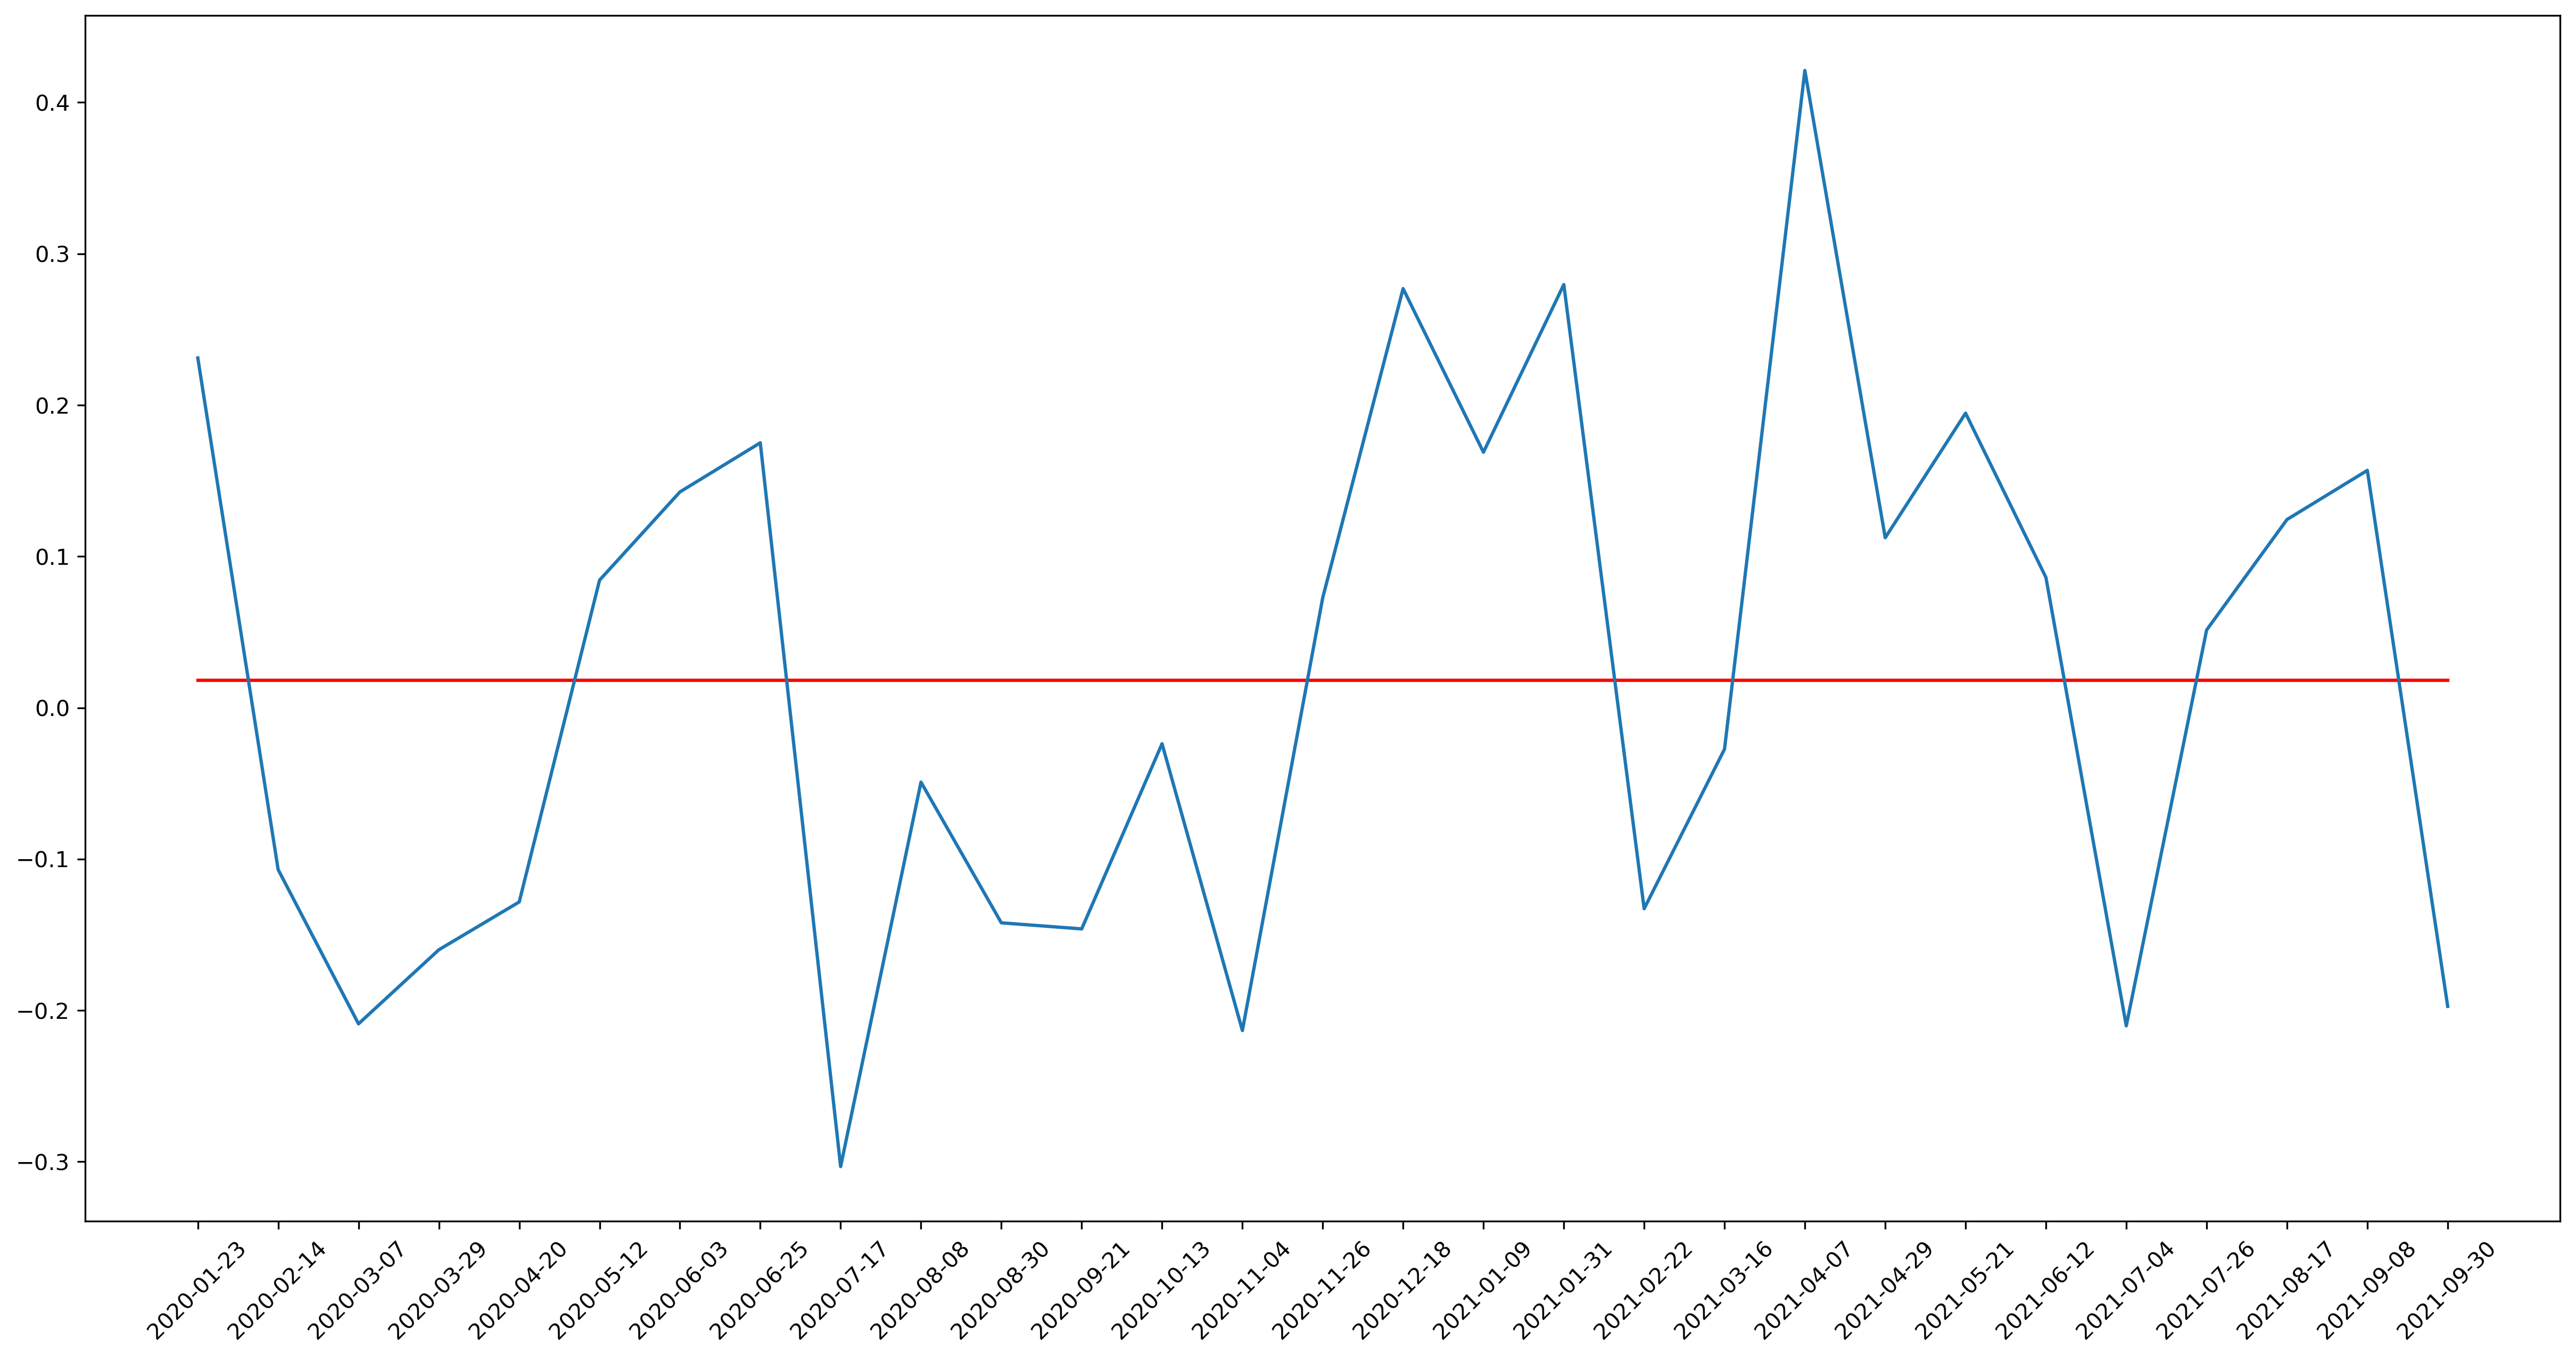

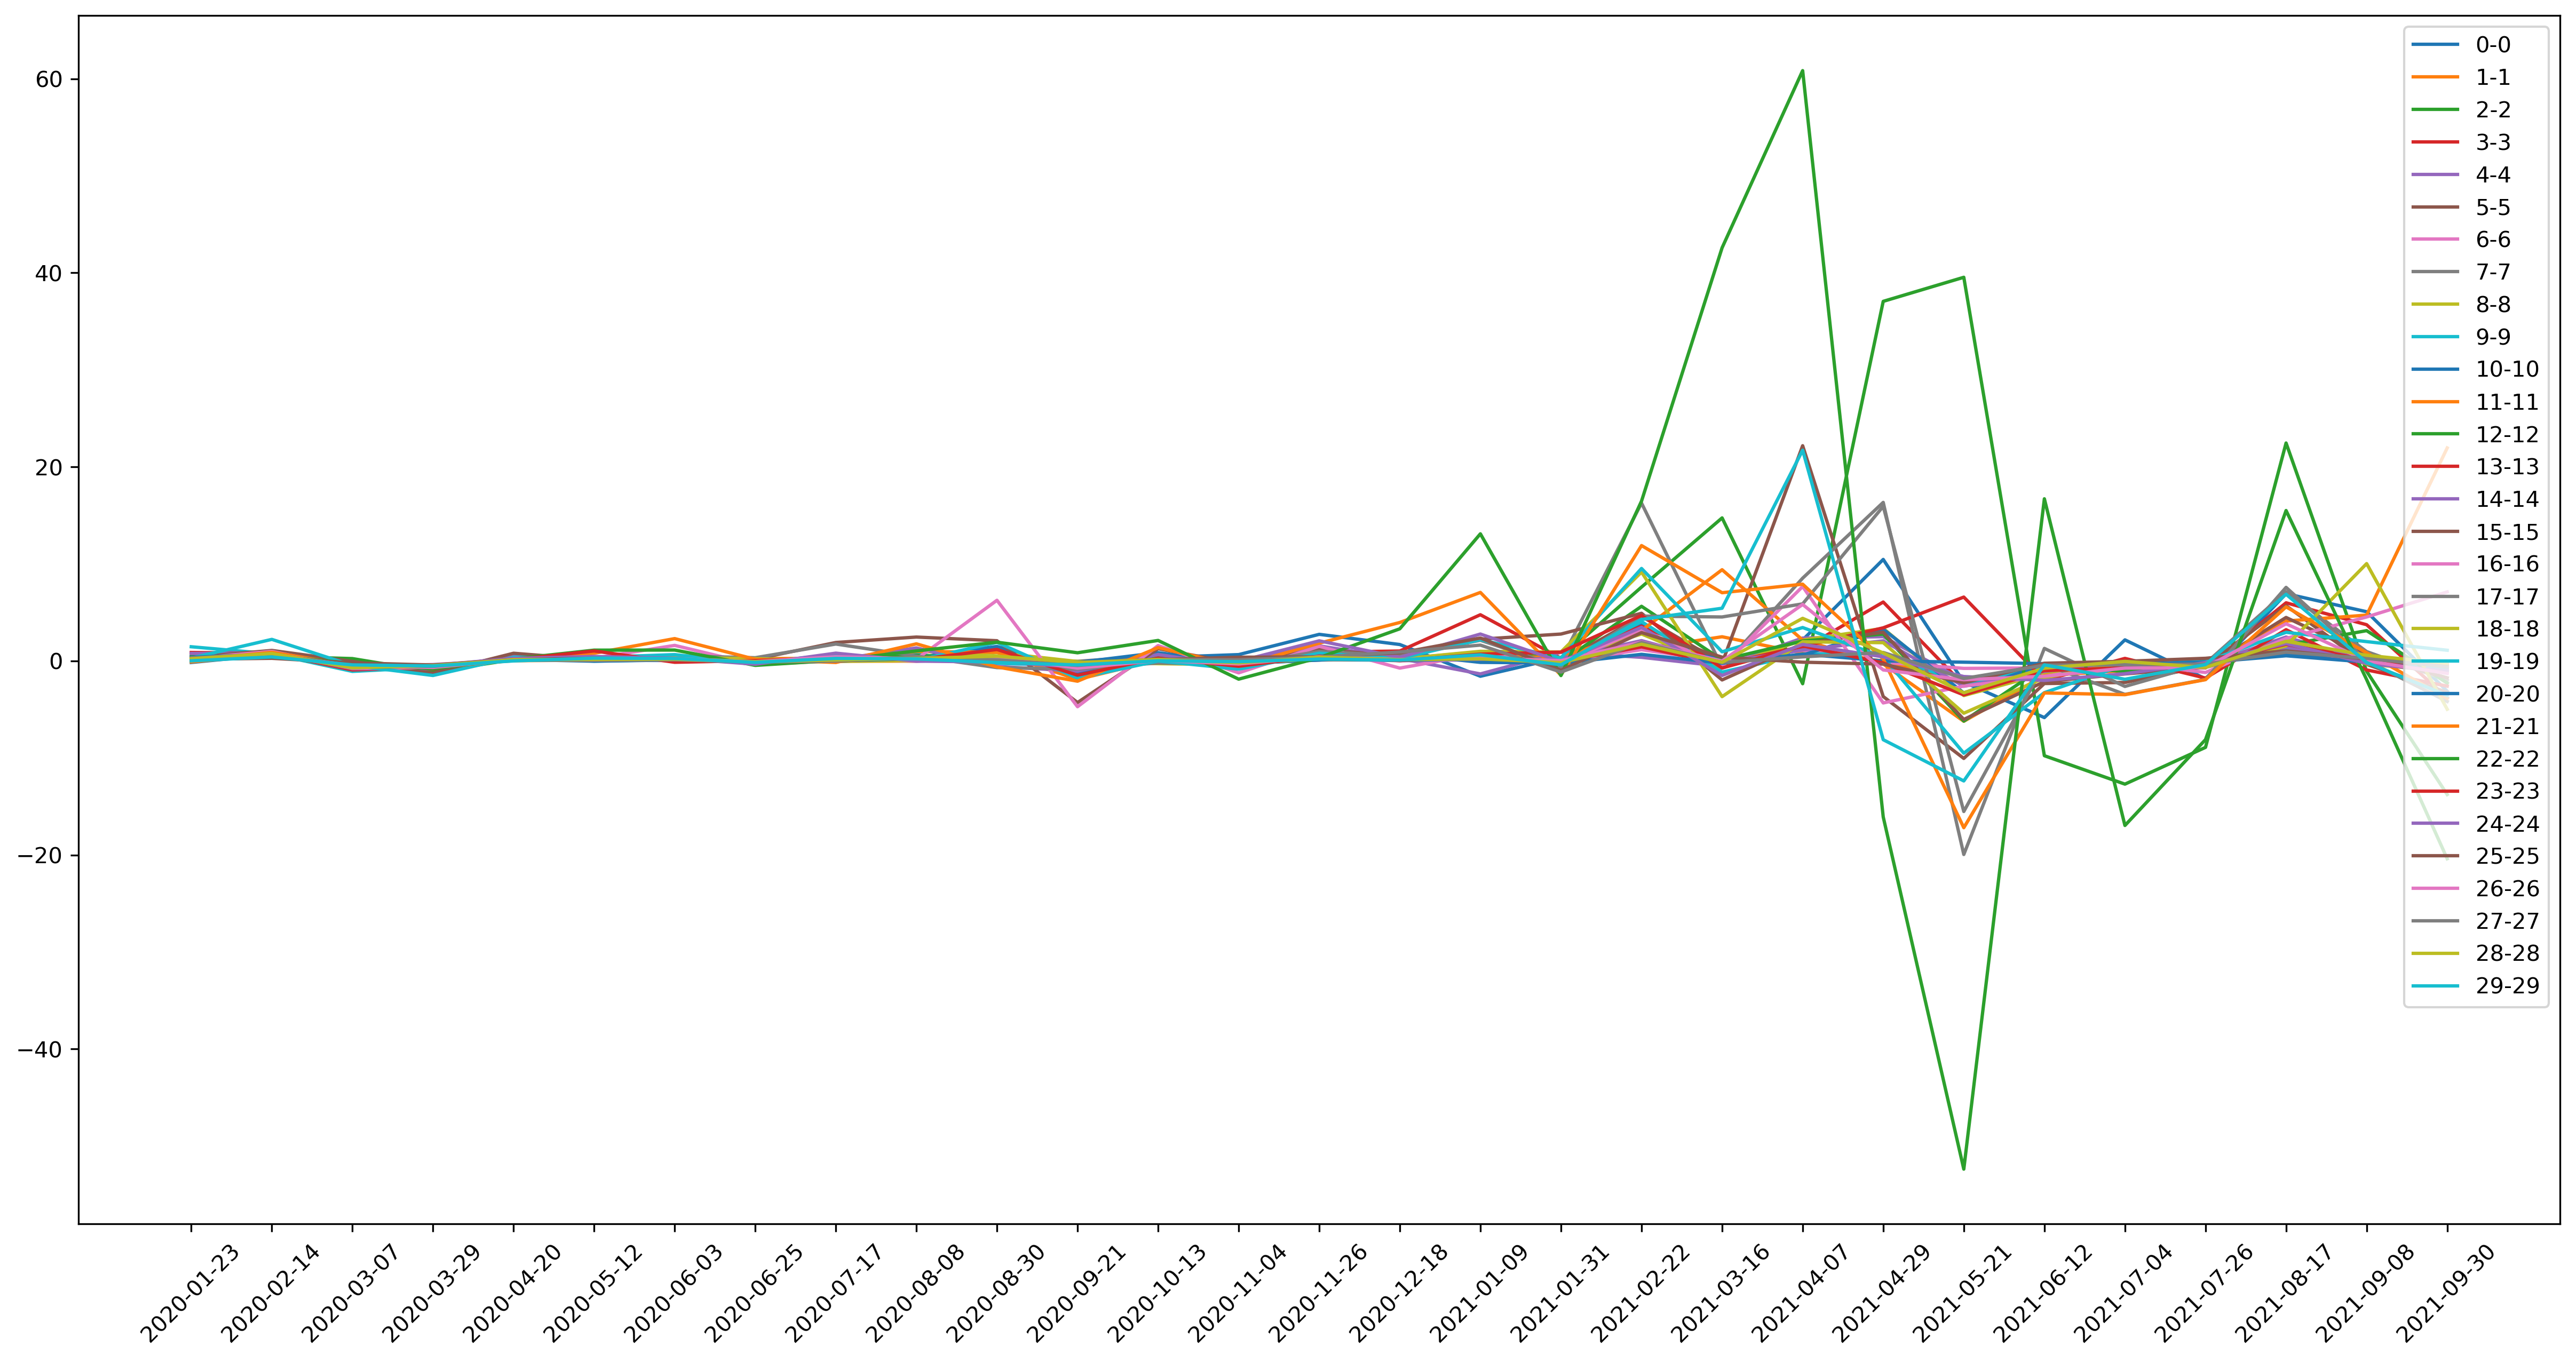

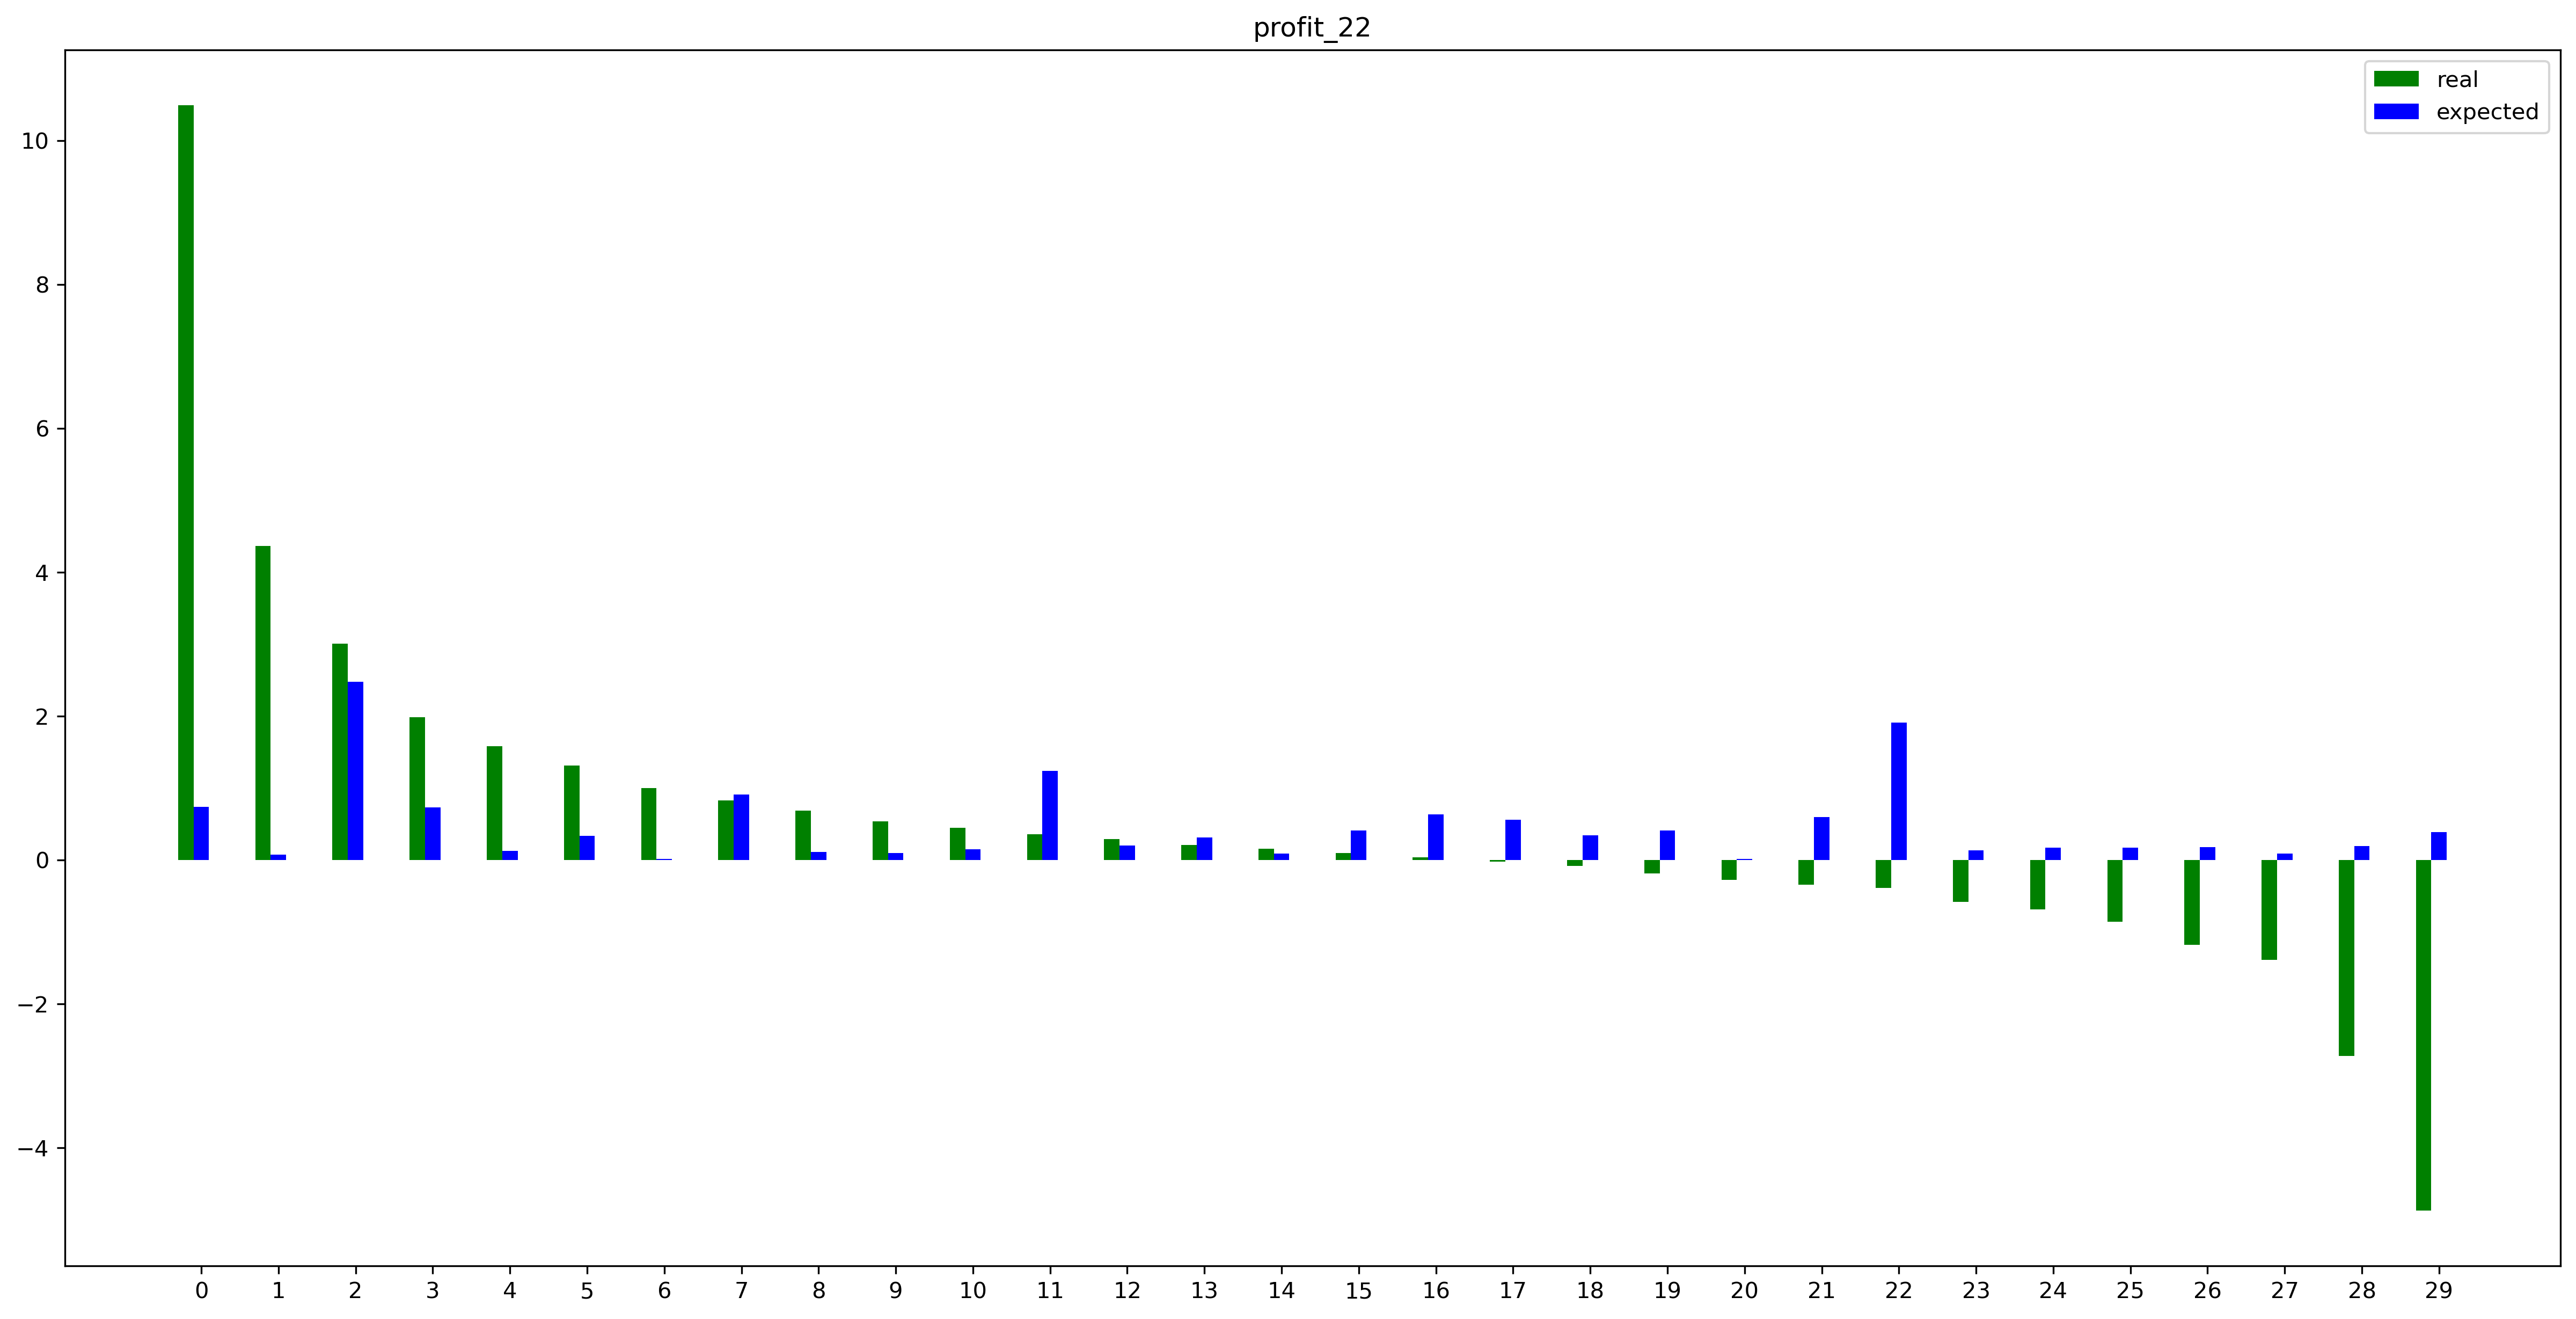

In [12]:
factor_list = conf['factor_list']
weight_list = conf['weight_list']
factor_profit('2020-01-01', '2021-10-01', datas, '1D', factor_list=factor_list, weight_list=weight_list, period=22, #period是调仓周期
                  outdir=outdir, symbols=symbols, showplt=showplt, saveplt=saveplt, title='profit')

### 皮尔逊相关系数

上面两个图分别是皮尔逊相关系数和预期收益，这里的相关系数是排名相关性，所以理论上我们希望每一期的排名都是强相关的。那意味着在因子分析的过程中，我们需要希望皮尔逊相关系数总体分布上更多的落在正数区间，越接近1越好。
从上面的结果来看，相关系数在零线上下两边的分布几乎是均等的，那意味着反转10这个因子在周期7的排名上是没有意义的。不过仅仅从这个角度，还不能说明这个因子不具备选股能力，因为如果在某一段排名上收益特别突出，其实也可以用来选股（币）。这种情况还没遇到，不过可以留意，假如3-5名上的因子收益在每一期总是非常好，那也可以做多排名这几位的币。因为反转因子在经济学意义上本身就很适用于选股。

### 排名平均收益

**待增加分层每一期画图的改进：分3-5层，主要用于观察单调性和走线相互独立不交叉。开发建议上保留上面的功能，然后加一个图表展示分层回测（总币数/n为一个投资组合，展示收益。比如总池30，分3层，那排名top10一组，10-20一组，20-30一组。同一个canvas上回测画线，来展示效果，参数n作为传入变量，灵活修改），n通常不会大于5，不然线可能会缠绕交叉的很厉害**

在我们的profit模块功能中，按得分进行排名（模型会多前空后），实际收益则代表当期实际收益最高最低的币（做空实际收益最低的币会赚钱），排名平均收益反应了在每一期上排名x的币所取得的收益在全周期上的累计均值。

从图中分析可知，该因子收益和排名相关性不高，而且在后三位空单上表现差强人意


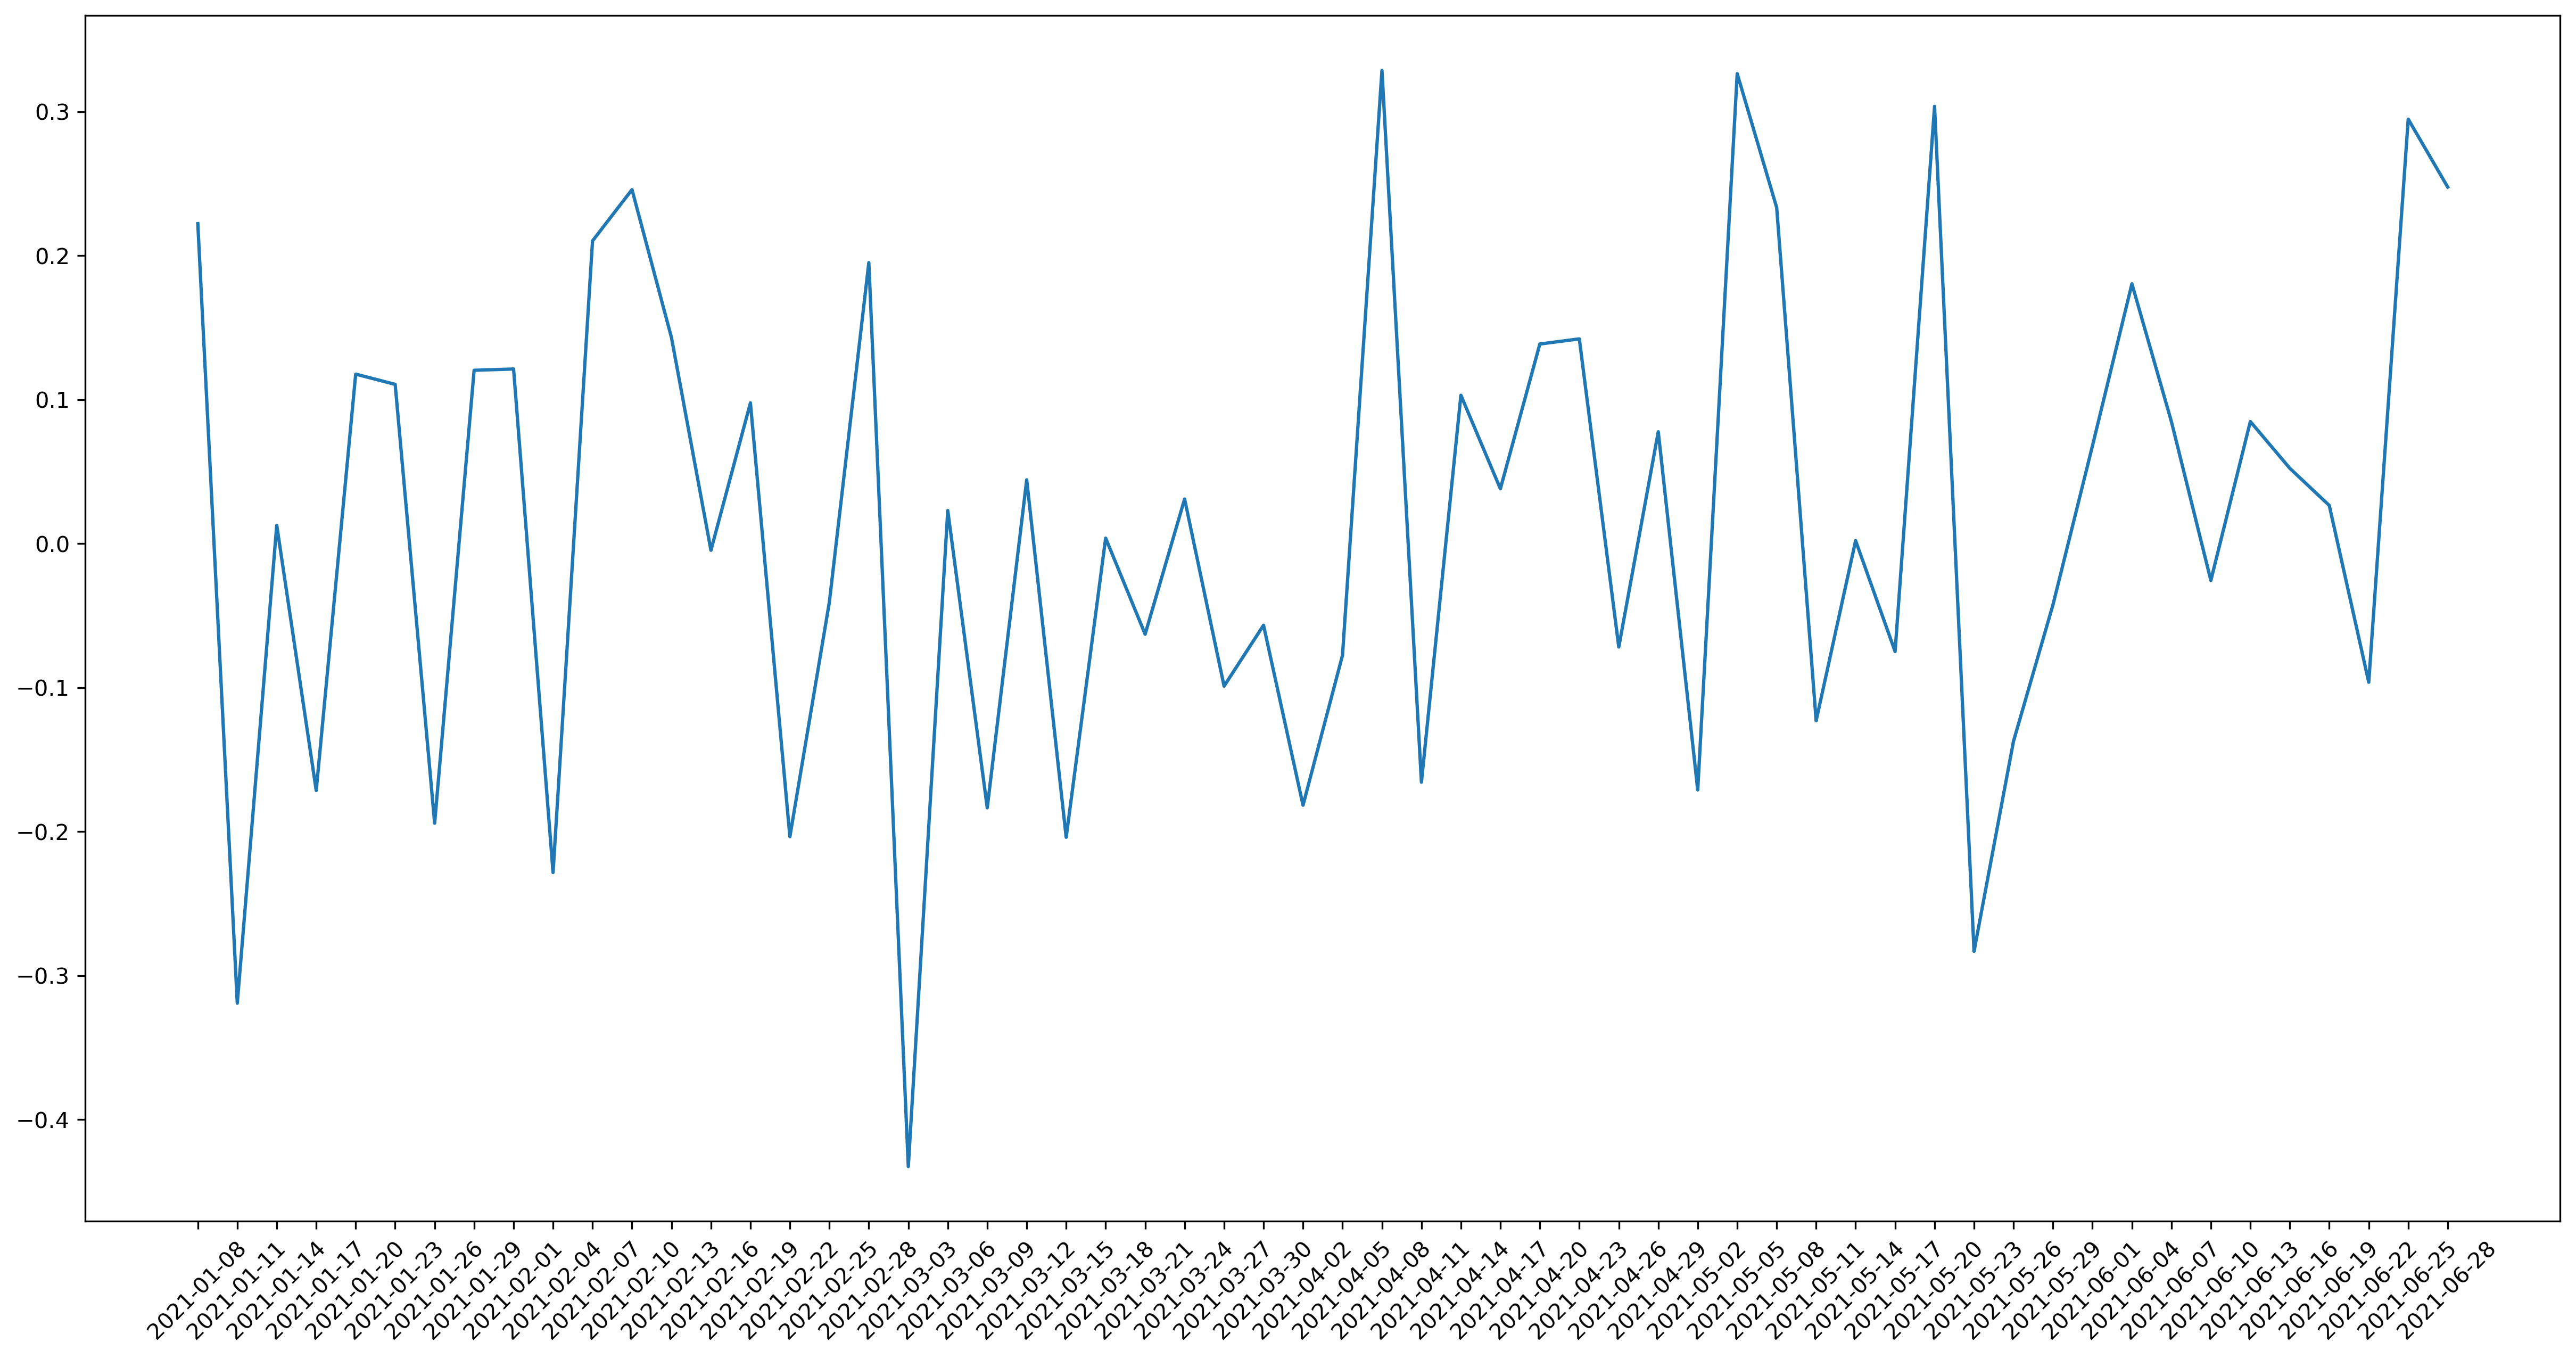

C:\alkaid\tools\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\alkaid\tools\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\alkaid\tools\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


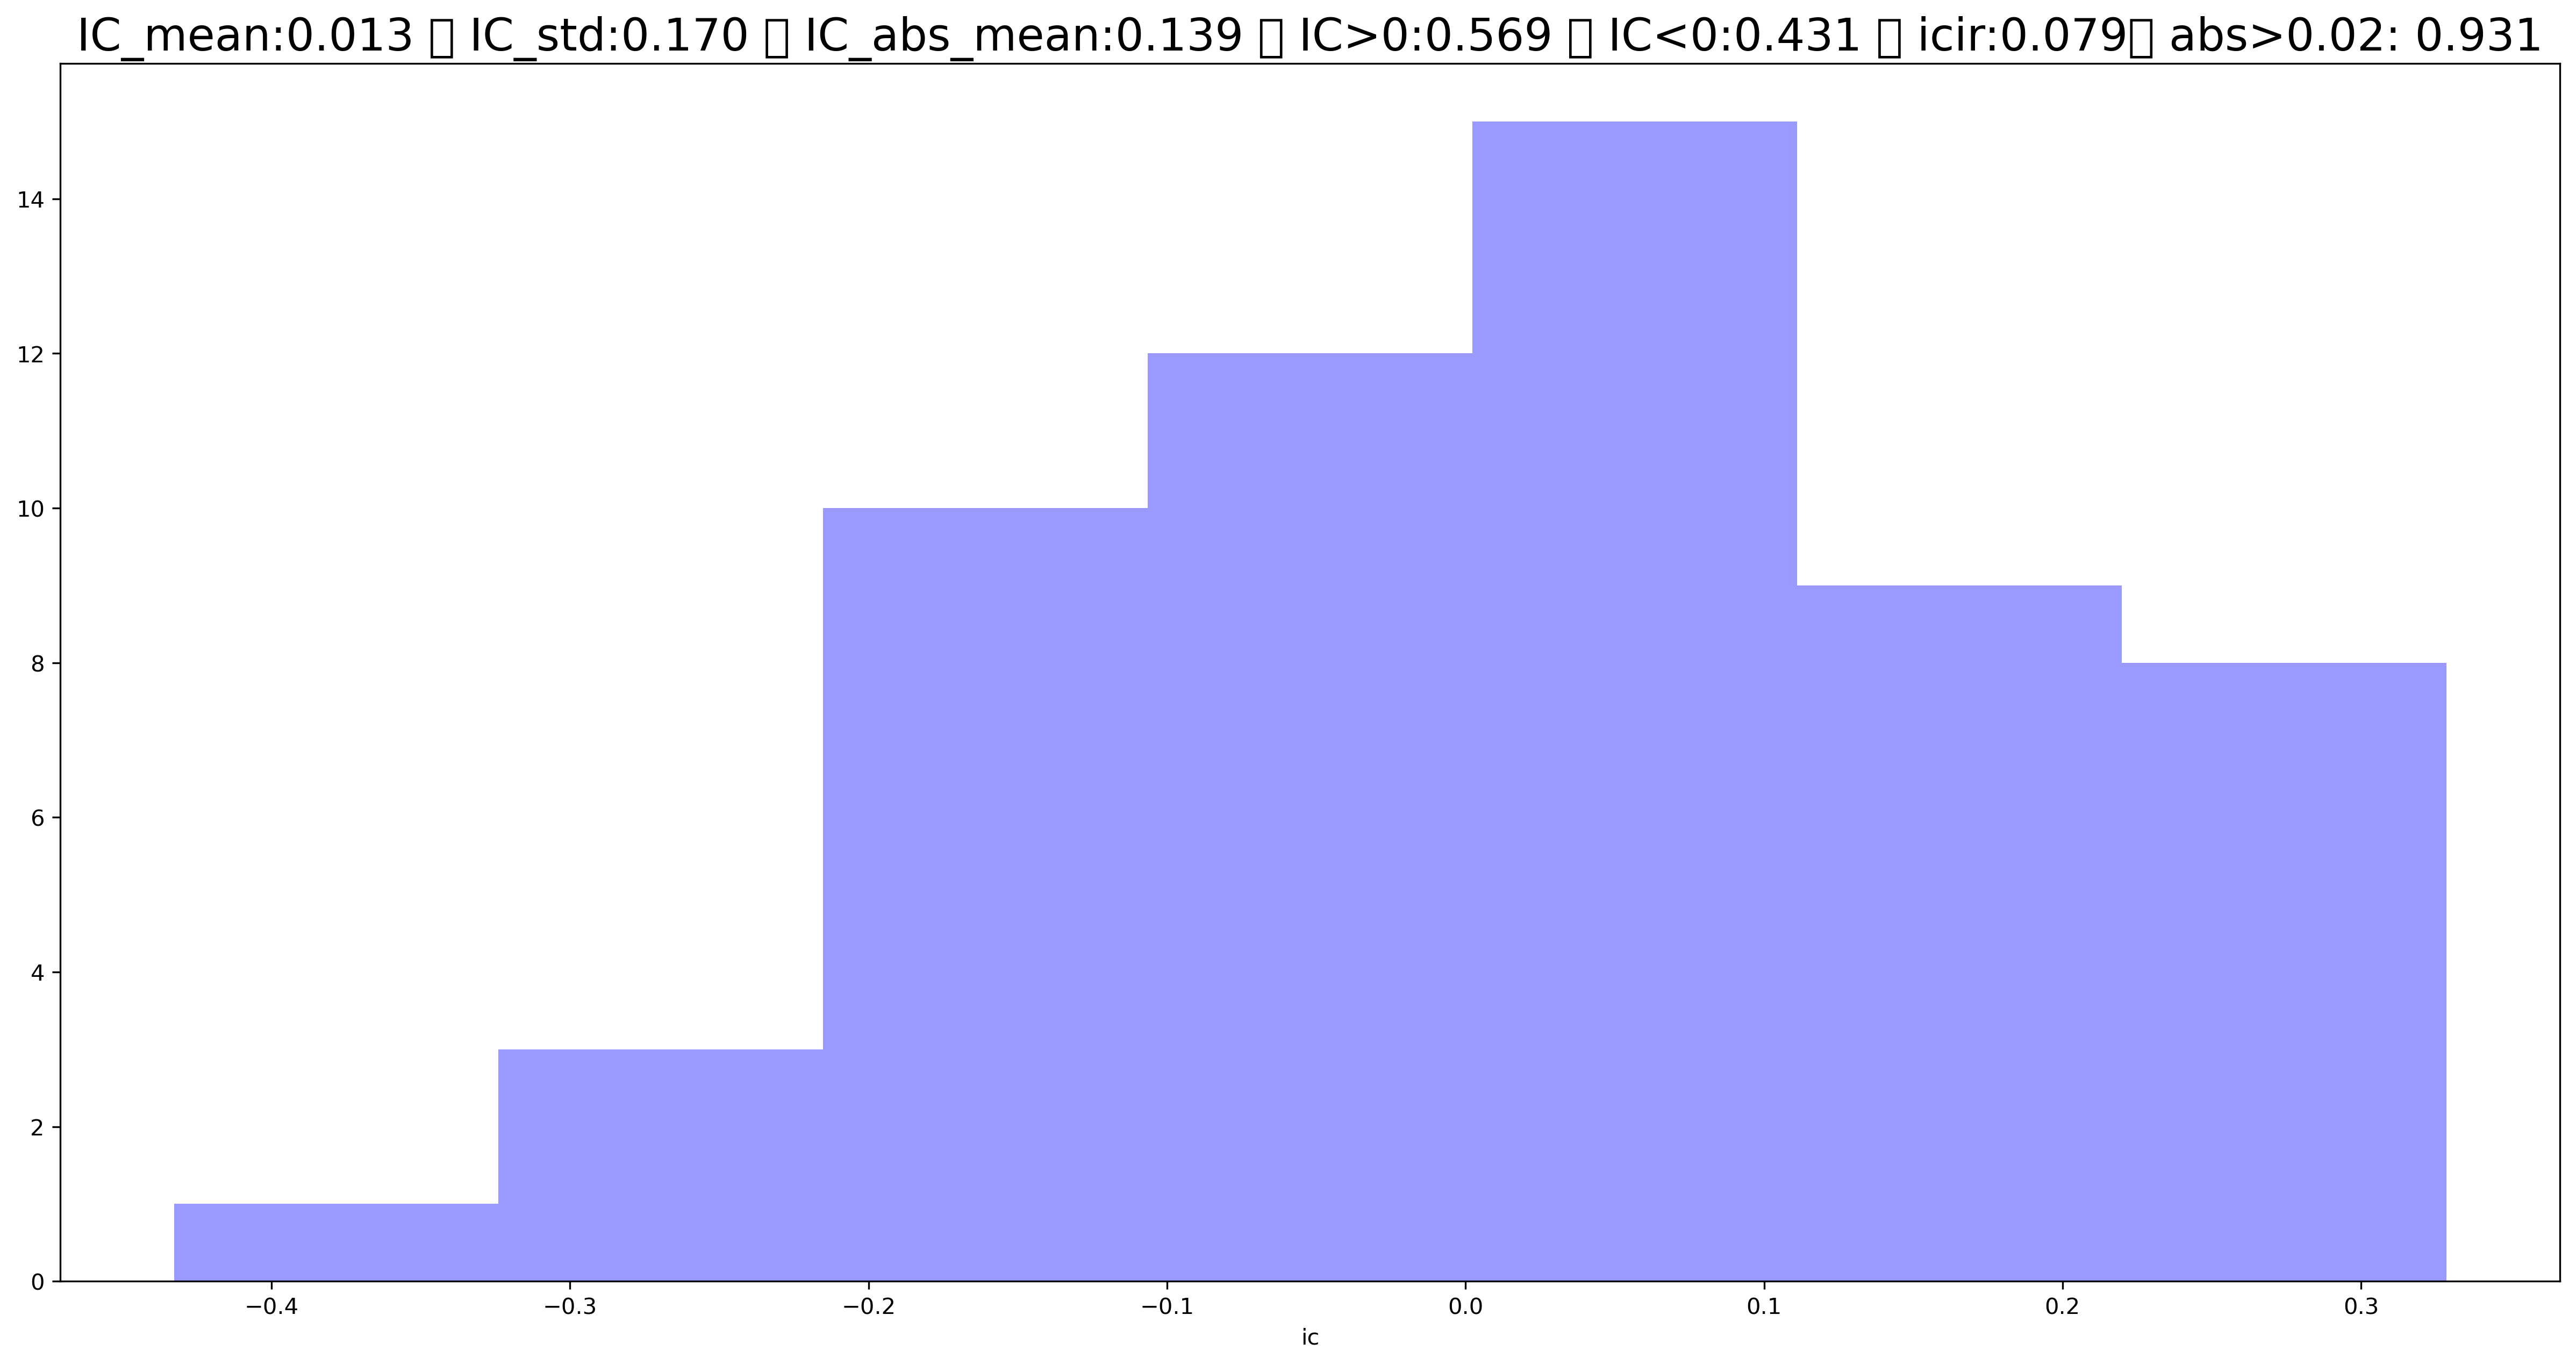

In [6]:

# 矩阵相关性这块后续进一步研究或改进
# symbol_pearsonr('2020-01-01', '2021-10-08', '7D', datas, '1D', factor_list=factor_list, outdir=outdir,
#                 symbols=symbols, showplt=showplt, saveplt=saveplt)

# calculate_pearsonr('2020-01-01','2021-07-10','7D',datas,'1D',factor_list=factor_list,outdir=outdir,symbols=symbols,showplt=showplt,saveplt=saveplt)
# ic_rankr('20210105', '20210630', '3D', datas, '1D', symbols=symbols)
ic_rank('20210105', '20210630', '3D', datas, '1D') 

IC反应了因子的预测能力，原则上当然是越大越好。不过从分布来看，该因子整体呈现噪声分布，表现是不佳的。

### 比照
在上述表现中，func.get_n_days_reverse, 10 的效果并不好。数字货币的周期通常相对更短，修改更短的回溯周期3天，func.get_n_days_reverse, 3 并用更长的调仓周期，可见在2020年中，其排名相关性显著提升，相较于之前的因子，收益更佳

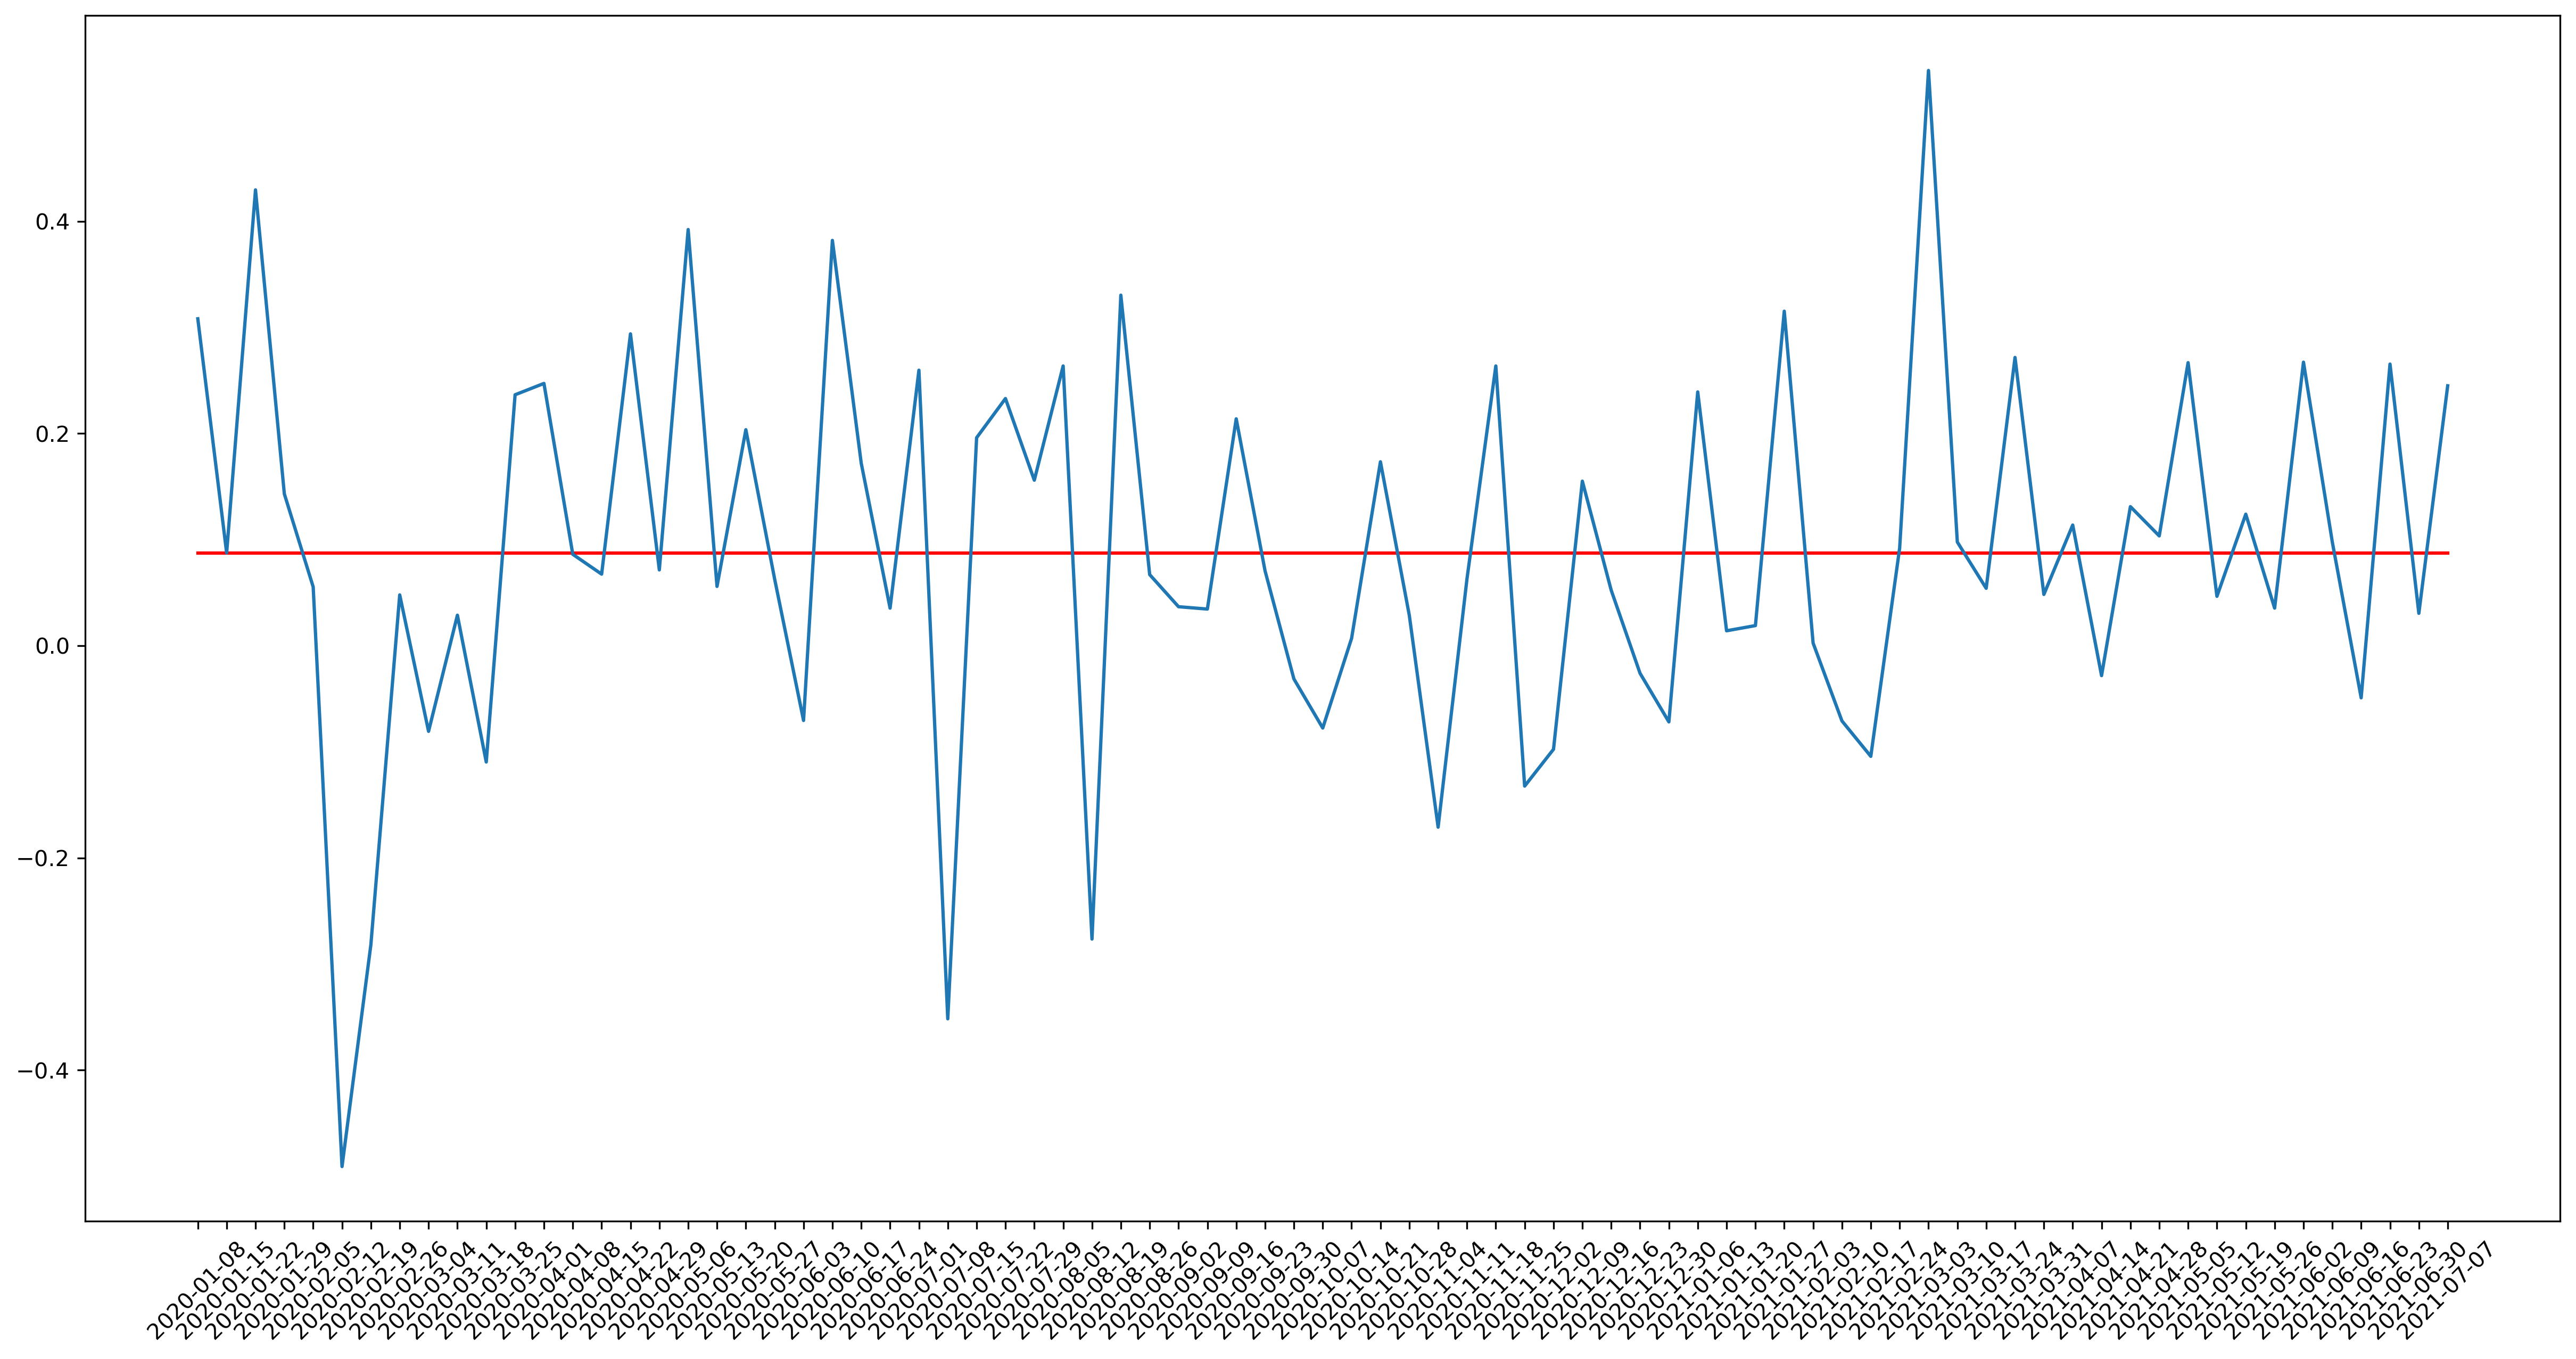

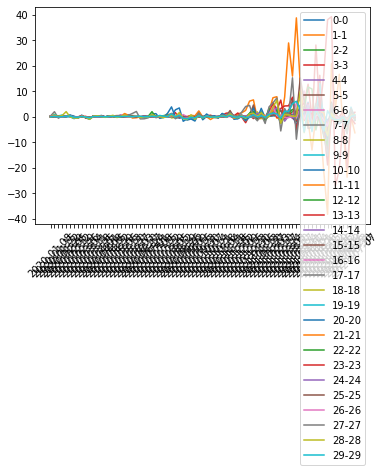

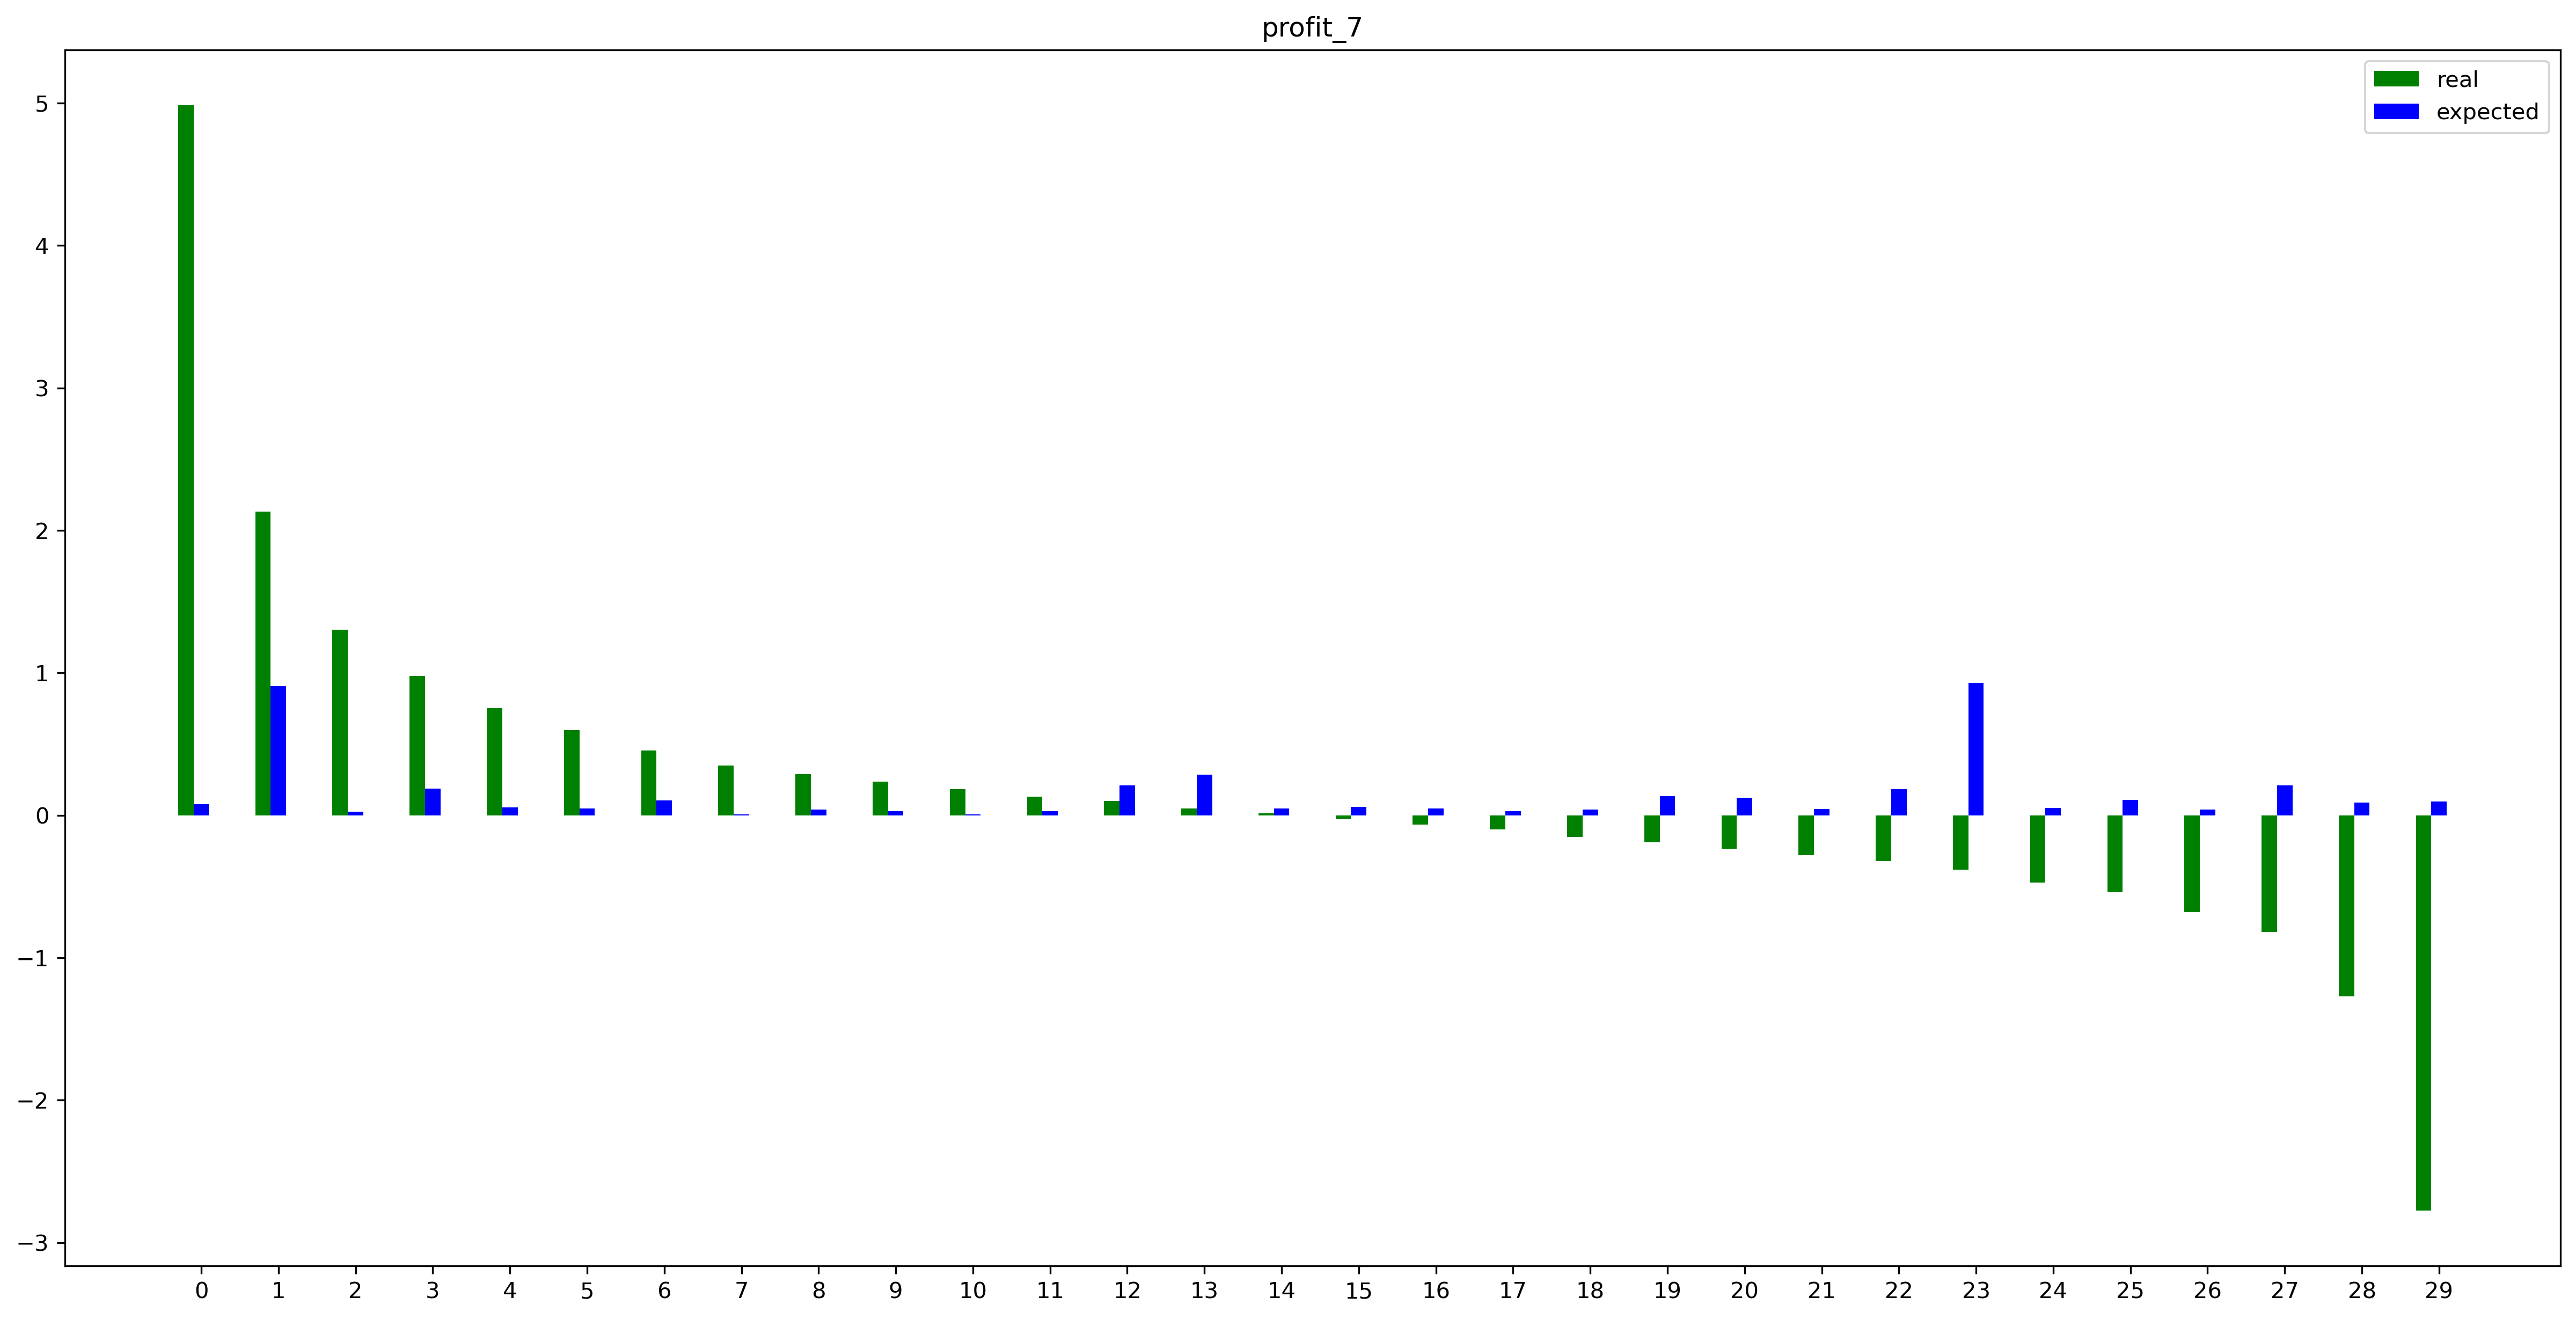

In [7]:
factor_list2 =[(func.get_n_days_liquidity, 5)
                   ]
weight_list2 = [1]
factor_profit('2020-01-01', '2021-07-10', datas, '1D', factor_list=factor_list2, weight_list=weight_list2, period=7,
                  outdir=outdir, symbols=symbols, showplt=showplt, saveplt=saveplt, title='profit')

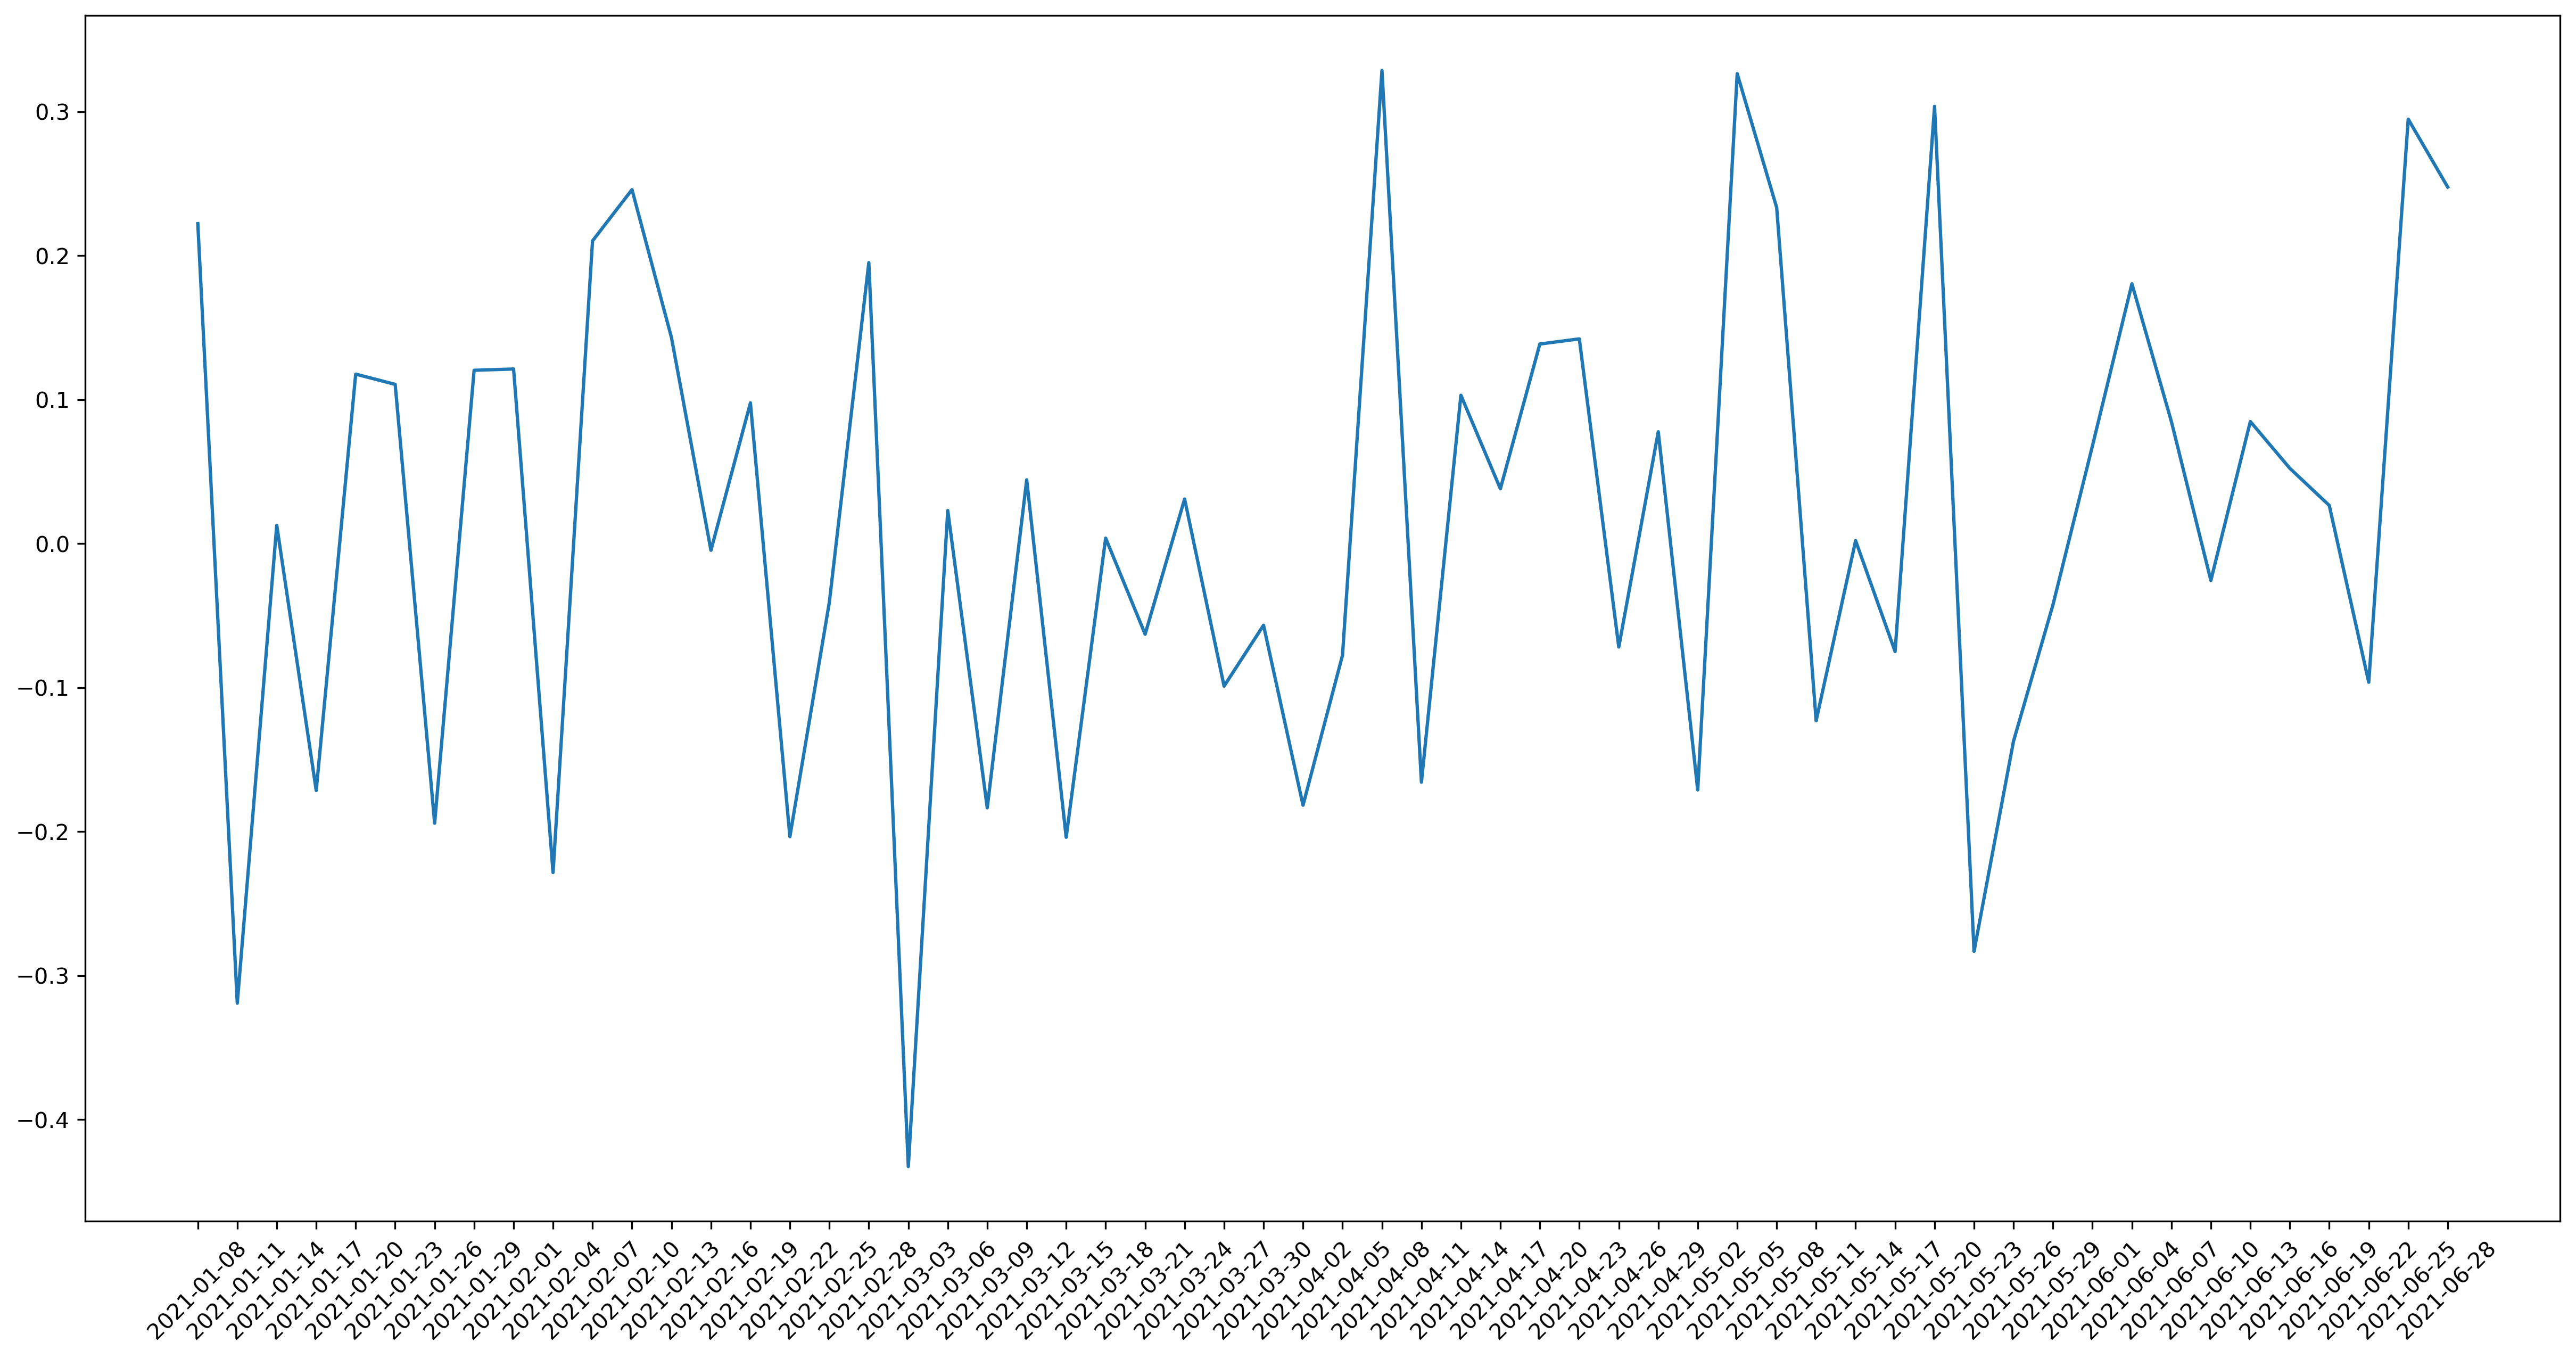

C:\alkaid\tools\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\alkaid\tools\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\alkaid\tools\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


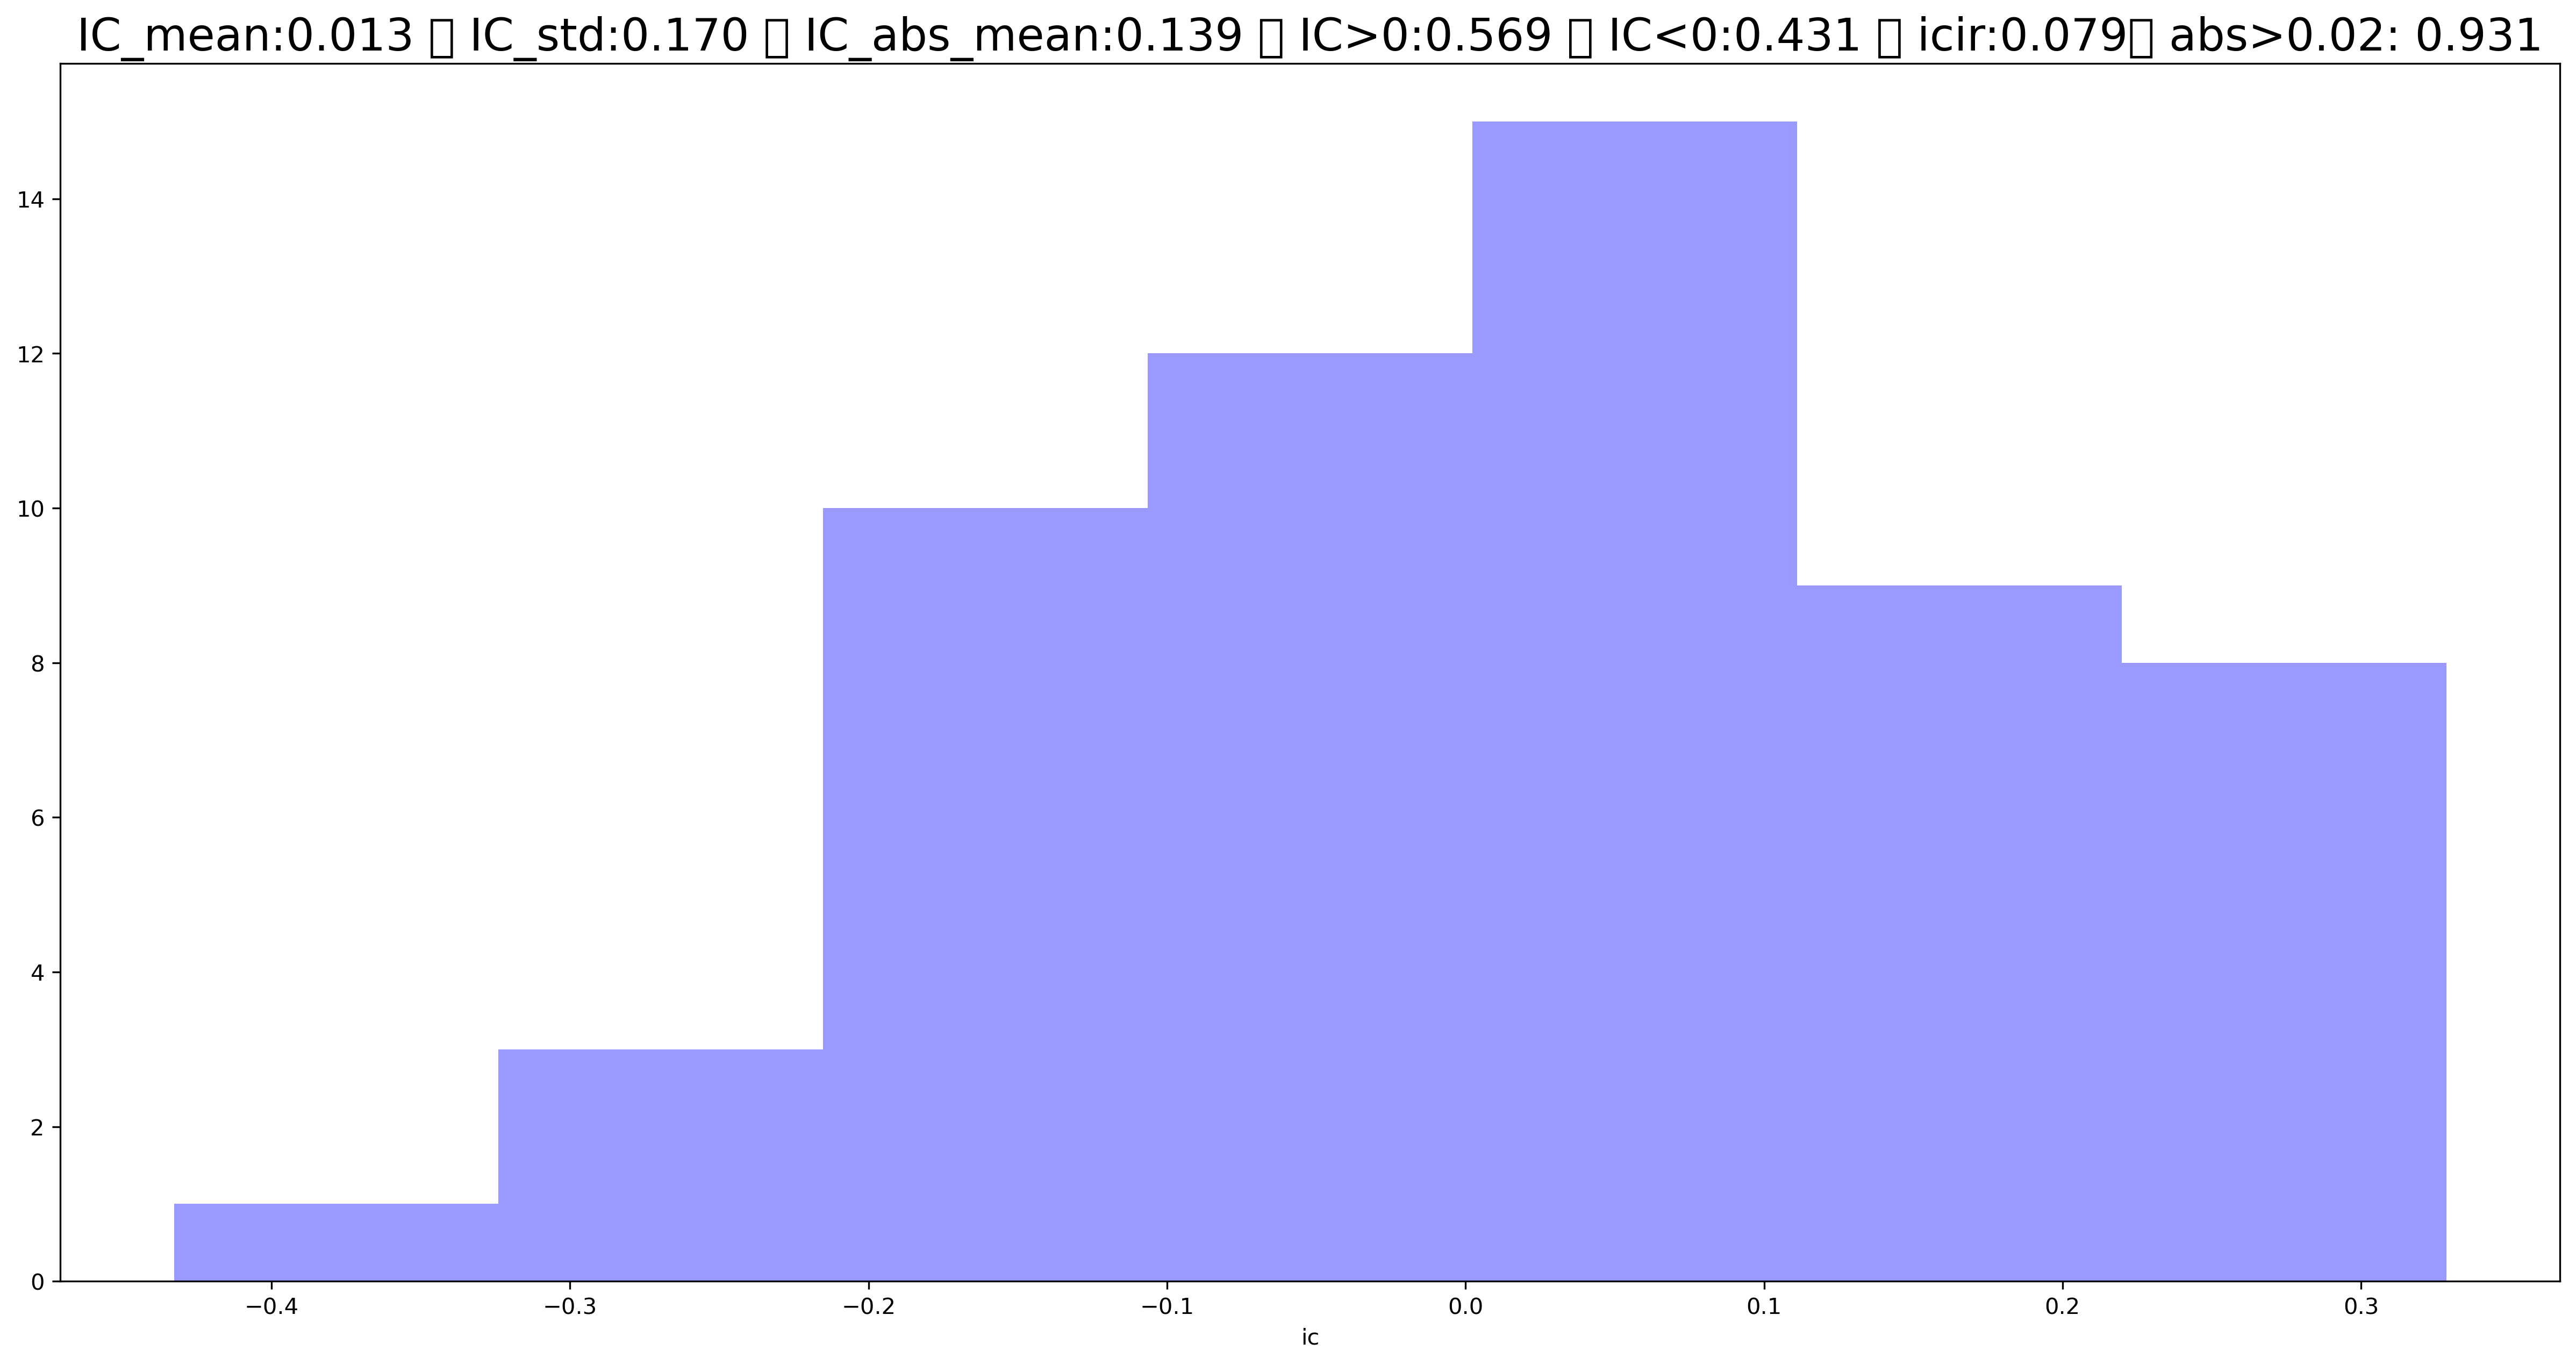

In [9]:
ic_rank('20210105', '20210630', '3D', datas, '1D') 

从因子ic来看，相较于上图，中间的波动减少了，说明修改后的因子稳定性更强，但预测能力仍然不显著。也许在短周期上会有效果。IC评估并不绝对，很多技术面因子都呈现噪声形态，但依然可以通过比较IC形态来迭代更优因子。不过优秀的因子IC会形成“单边形态”，IC的均值线显著大于0或者1（后续做成柱状图展示会更容易判断）

In [ ]:
# bootstrap r-square

### bootstrap显著性检验



#### 资产数据应用moving block bootstrap抽样
首先选取一个长度为n的目标序列，选择长度b作为分割长度的序列(即每次抽取序列的长度)
将原序列(长度为n的序列)尽可能多的分割成长度为b的重叠的(overlaping)子序列，总共可以分割成n-b+1个重叠子序列。
由于每个序列长度为b，总共仅需n/b个序列即可组成与原序列等长的序列。因而在总共n-b+1个序列中随机抽取n/b个序列。
最后，再将抽出来的n/b个序列按照其抽样顺序重新组合，即可得到bootstrap序列。
这里我们令 block size = 4，进行 1000 次 stationary bootstrap，得到 1000 个 bootstrapped 样本。